In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import PIL
from tqdm import tqdm
from PIL import Image, ImageMath
from img_processing_256 import random_flip_img_train

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_png_files (src, dst):
    for root, subdir, files in os.walk(src):
        for file in files:
            ext = os.path.splitext(file)[-1]
            if ext == '.png':
                path = os.path.join(root,file)
                shutil.move(path, dst)

## Howtek Scanner - DDSM Normal

In [3]:
#Scanner type: Howteck. 
folder_name0 = 'Normal07'
folder_name1 = 'Normal08'
folder_name2 = 'Normal11'
folder_name3 = 'Normal12'

folders_name = [folder_name0, folder_name1, folder_name2, folder_name3]

for folder_name in folders_name:
    src = r'C:\Users\kk64\Downloads\Capstone\data\Normal'+'/'+folder_name
    dst = r'C:\Users\kk64\Documents\Howtek'+'/'+folder_name
    get_png_files(src,dst)

## Lumysis Scanner - DDSM Normal

In [4]:
#Scanner type: Lumysis
folder_name0 = 'Normal09'
folder_name1 = 'Normal10'

folders_name = [folder_name0, folder_name1]

for folder_name in folders_name:
    src = r'C:\Users\kk64\Downloads\Capstone\data\Normal'+'/'+folder_name
    dst = r'C:\Users\kk64\Documents\Lumysis'+'/'+folder_name
    get_png_files(src,dst)

## Suppress Artifacts

In [4]:
ori_img = cv2.imread('Normal/Howtek/Normal11/A_1964_1.LEFT_MLO.png',
          cv2.IMREAD_GRAYSCALE)

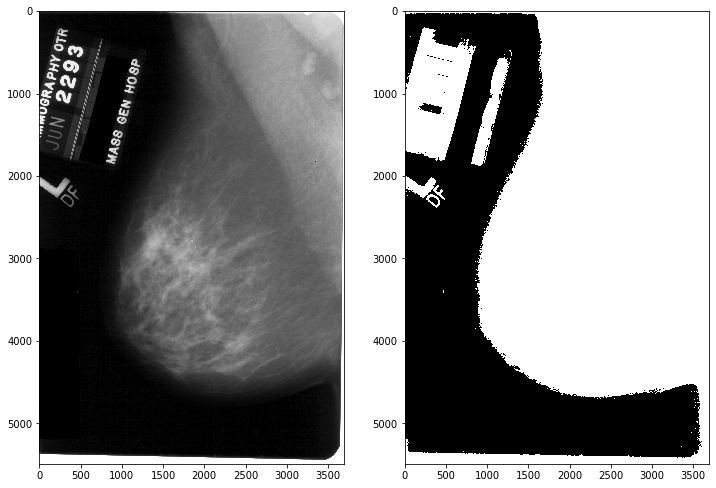

In [5]:
threshold = 18  # from Nagi thesis. <<= para to tune!
_, binary_img = cv2.threshold(ori_img, threshold, 
                                maxval=255, type=cv2.THRESH_BINARY)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(ori_img, cmap='gray')
axes[1].imshow(binary_img, cmap='gray')

In [6]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    '''Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin(2D array): 2D numpy array of binary image.
        lab_val([int]): integer value used for the label of the largest 
                        object. Default is 255.
        fill_holes([boolean]): whether fill the holes inside the largest 
                               object or not. Default is false.
        smooth_boundary([boolean]): whether smooth the boundary of the 
                                    largest object using morphological 
                                    opening or not. Default is false.
        kernel_size([int]): the size of the kernel used for morphological 
                            operation.
    '''
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(
        img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)
        
    return largest_mask

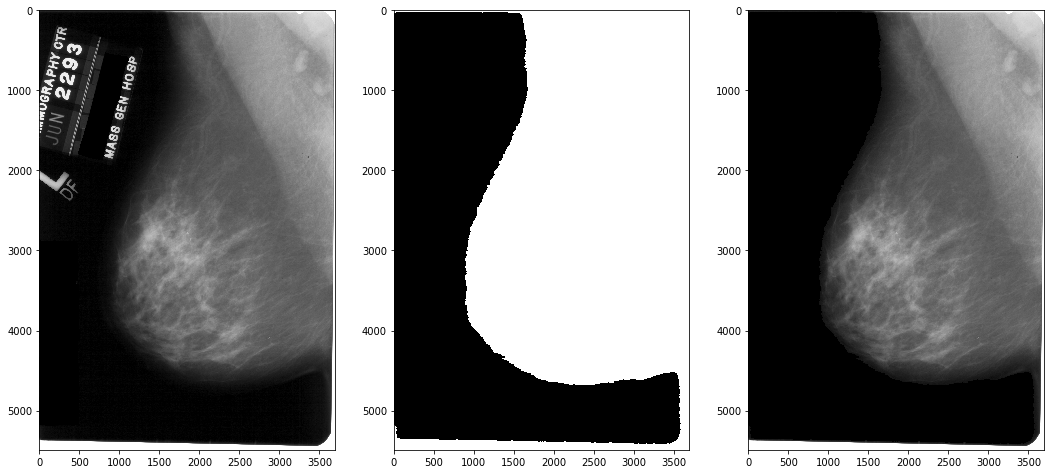

In [7]:
mask_img = select_largest_obj(binary_img, lab_val=255, 
                                       fill_holes=True, 
                                       smooth_boundary=True, kernel_size=15)  # <<= para to tune!
filtered_img = cv2.bitwise_and(ori_img, mask_img)
fig,axes = subplots(1,3)
fig.set_size_inches([18, 9])
axes[0].imshow(ori_img, cmap='gray')
axes[1].imshow(mask_img, cmap='gray')
axes[2].imshow(filtered_img, cmap='gray')

In [12]:
def normal_patch_slices(src, upper_thresh=0, lower_thresh=0, mean_thresh=0, stride=200):
    files = os.listdir(src)
    patch_slices = []
    patch_labels = []
    patch_FileNames = []
    
    i = 0
    for file in tqdm(files):
        
        file_name = file
        
        if True:
            print(i, "-", file)
        i += 1
        
        """
        suppress artifacts in image   
        """       
        ori_img=cv2.imread(os.path.join(src, file),cv2.IMREAD_GRAYSCALE)
        
        thresh = 18  # from Nagi thesis. <<= para to tune!
        _, binary_img = cv2.threshold(ori_img, thresh, maxval=255, type=cv2.THRESH_BINARY)
        
        mask_img = select_largest_obj(binary_img, lab_val=255, 
                                       fill_holes=True, 
                                       smooth_boundary=True, kernel_size=15)  # <<= para to tune!
        
        processed_img = cv2.bitwise_and(ori_img, mask_img)
        
        """
        adjust image size and create image slices
        """
        h, w = processed_img.shape
        hmargin = int(h * 0.07)
        wmargin = int(w * 0.07)
        
        img = processed_img[hmargin:h-hmargin, wmargin:w-wmargin]
    
        """
        create 256x256 tiles
        """
        size = 512
        
        tiles = [img[x:x+size,y:y+size] for x in range(0,img.shape[0],stride) for y in range(0,img.shape[1],stride)]
        
        
        """
        filter tiles
        """
        filtered_tiles = []
    
        for i in range(len(tiles)):
            if tiles[i].shape == (size,size):
                if (np.sum(np.sum(tiles[i] >= 225)) < 100) and (np.sum(np.sum(tiles[i] <= 20)) <= 50000):  #filter abnormal tiles
                    if np.mean(tiles[i]) >= mean_thresh: # make sure tile has stuff in it
                        if np.var(tiles[i]) <= upper_thresh: # make sure the tile contains image and not mostly empty space
                            if np.var(tiles[i]) >= lower_thresh:
                                cropped_img = np.array(Image.fromarray(tiles[i]).resize((256,256))) # size the tile down to 256x256
                                
                                filtered_tiles.append(random_flip_img_train(cropped_img.reshape(256,256,1)))
        
        for tile in filtered_tiles:
            patch_slices.append(tile)
            patch_labels.append("NORMAL")
            patch_FileNames.append(file_name)
        
    assert(len(patch_slices) == len(patch_labels))
    
    return np.array(patch_slices), np.array(patch_labels), np.array(patch_FileNames)

## Howtek Patches

In [13]:
#Howteck Normal07
src = 'Normal/Howtek/Normal07/'
norm07_patches, norm07_labels, norm07_FNs = normal_patch_slices(src, upper_thresh=10000, lower_thresh=10, mean_thresh=30, stride=300)

  0%|                                                                                          | 0/312 [00:00<?, ?it/s]

0 - D_4500_1.LEFT_CC.png


  0%|▎                                                                                 | 1/312 [00:00<01:44,  2.97it/s]

77 - D_4500_1.LEFT_MLO.png


  1%|▌                                                                                 | 2/312 [00:00<02:06,  2.45it/s]

111 - D_4500_1.RIGHT_CC.png


  1%|▊                                                                                 | 3/312 [00:01<02:14,  2.29it/s]

83 - D_4500_1.RIGHT_MLO.png


  1%|█                                                                                 | 4/312 [00:02<02:39,  1.94it/s]

111 - D_4501_1.LEFT_CC.png


  2%|█▎                                                                                | 5/312 [00:03<03:36,  1.42it/s]

175 - D_4501_1.LEFT_MLO.png


  2%|█▌                                                                                | 6/312 [00:04<04:18,  1.18it/s]

191 - D_4501_1.RIGHT_CC.png


  2%|█▊                                                                                | 7/312 [00:05<04:45,  1.07it/s]

191 - D_4501_1.RIGHT_MLO.png


  3%|██                                                                                | 8/312 [00:06<05:14,  1.03s/it]

191 - D_4502_1.LEFT_CC.png


  3%|██▎                                                                               | 9/312 [00:07<04:37,  1.09it/s]

119 - D_4502_1.LEFT_MLO.png


  3%|██▌                                                                              | 10/312 [00:08<04:24,  1.14it/s]

143 - D_4502_1.RIGHT_CC.png


  4%|██▊                                                                              | 11/312 [00:08<04:04,  1.23it/s]

119 - D_4502_1.RIGHT_MLO.png


  4%|███                                                                              | 12/312 [00:09<04:07,  1.21it/s]

143 - D_4503_1.LEFT_CC.png


  4%|███▍                                                                             | 13/312 [00:10<03:32,  1.41it/s]

97 - D_4503_1.LEFT_MLO.png


  4%|███▋                                                                             | 14/312 [00:10<03:20,  1.49it/s]

111 - D_4503_1.RIGHT_CC.png


  5%|███▉                                                                             | 15/312 [00:11<03:08,  1.57it/s]

97 - D_4503_1.RIGHT_MLO.png


  5%|████▏                                                                            | 16/312 [00:12<03:18,  1.49it/s]

127 - D_4505_1.LEFT_CC.png


  5%|████▍                                                                            | 17/312 [00:12<03:27,  1.42it/s]

143 - D_4505_1.LEFT_MLO.png


  6%|████▋                                                                            | 18/312 [00:13<03:43,  1.32it/s]

143 - D_4505_1.RIGHT_CC.png


  6%|████▉                                                                            | 19/312 [00:14<03:50,  1.27it/s]

143 - D_4505_1.RIGHT_MLO.png


  6%|█████▏                                                                           | 20/312 [00:15<04:11,  1.16it/s]

175 - D_4506_1.LEFT_CC.png


  7%|█████▍                                                                           | 21/312 [00:16<03:34,  1.36it/s]

97 - D_4506_1.LEFT_MLO.png


  7%|█████▋                                                                           | 22/312 [00:16<03:02,  1.59it/s]

83 - D_4506_1.RIGHT_CC.png


  7%|█████▉                                                                           | 23/312 [00:16<02:40,  1.80it/s]

71 - D_4506_1.RIGHT_MLO.png


  8%|██████▏                                                                          | 24/312 [00:17<02:34,  1.86it/s]

83 - D_4508_1.LEFT_CC.png


  8%|██████▍                                                                          | 25/312 [00:17<02:23,  2.00it/s]

77 - D_4508_1.LEFT_MLO.png


  8%|██████▊                                                                          | 26/312 [00:18<02:23,  1.99it/s]

104 - D_4508_1.RIGHT_CC.png


  9%|███████                                                                          | 27/312 [00:18<02:18,  2.05it/s]

77 - D_4508_1.RIGHT_MLO.png


  9%|███████▎                                                                         | 28/312 [00:19<02:24,  1.97it/s]

104 - D_4509_1.LEFT_CC.png


  9%|███████▌                                                                         | 29/312 [00:19<02:21,  1.99it/s]

97 - D_4509_1.LEFT_MLO.png


 10%|███████▊                                                                         | 30/312 [00:20<02:33,  1.84it/s]

119 - D_4509_1.RIGHT_CC.png


 10%|████████                                                                         | 31/312 [00:21<02:39,  1.76it/s]

127 - D_4509_1.RIGHT_MLO.png


 10%|████████▎                                                                        | 32/312 [00:21<02:55,  1.60it/s]

143 - D_4510_1.LEFT_CC.png


 11%|████████▌                                                                        | 33/312 [00:22<03:06,  1.50it/s]

143 - D_4510_1.LEFT_MLO.png


 11%|████████▊                                                                        | 34/312 [00:23<03:17,  1.41it/s]

134 - D_4510_1.RIGHT_CC.png


 11%|█████████                                                                        | 35/312 [00:24<03:34,  1.29it/s]

143 - D_4510_1.RIGHT_MLO.png


 12%|█████████▎                                                                       | 36/312 [00:25<03:56,  1.17it/s]

175 - D_4511_1.LEFT_CC.png


 12%|█████████▌                                                                       | 37/312 [00:26<04:24,  1.04it/s]

191 - D_4511_1.LEFT_MLO.png


 12%|█████████▊                                                                       | 38/312 [00:27<04:44,  1.04s/it]

191 - D_4511_1.RIGHT_CC.png


 12%|██████████▏                                                                      | 39/312 [00:29<04:57,  1.09s/it]

175 - D_4511_1.RIGHT_MLO.png


 13%|██████████▍                                                                      | 40/312 [00:30<05:11,  1.14s/it]

191 - D_4512_1.LEFT_CC.png


 13%|██████████▋                                                                      | 41/312 [00:30<04:27,  1.01it/s]

119 - D_4512_1.LEFT_MLO.png


 13%|██████████▉                                                                      | 42/312 [00:31<04:05,  1.10it/s]

119 - D_4512_1.RIGHT_CC.png


 14%|███████████▏                                                                     | 43/312 [00:32<03:43,  1.20it/s]

111 - D_4512_1.RIGHT_MLO.png


 14%|███████████▍                                                                     | 44/312 [00:33<03:42,  1.20it/s]

127 - D_4513_1.LEFT_CC.png


 14%|███████████▋                                                                     | 45/312 [00:33<03:13,  1.38it/s]

97 - D_4513_1.LEFT_MLO.png


 15%|███████████▉                                                                     | 46/312 [00:34<02:55,  1.52it/s]

97 - D_4513_1.RIGHT_CC.png


 15%|████████████▏                                                                    | 47/312 [00:34<02:44,  1.61it/s]

97 - D_4513_1.RIGHT_MLO.png


 15%|████████████▍                                                                    | 48/312 [00:35<02:43,  1.62it/s]

104 - D_4514_1.LEFT_CC.png


 16%|████████████▋                                                                    | 49/312 [00:36<02:58,  1.48it/s]

143 - D_4514_1.LEFT_MLO.png


 16%|████████████▉                                                                    | 50/312 [00:36<03:13,  1.35it/s]

159 - D_4514_1.RIGHT_CC.png


 16%|█████████████▏                                                                   | 51/312 [00:37<03:31,  1.23it/s]

159 - D_4514_1.RIGHT_MLO.png


 17%|█████████████▌                                                                   | 52/312 [00:38<03:46,  1.15it/s]

159 - D_4515_1.LEFT_CC.png


 17%|█████████████▊                                                                   | 53/312 [00:39<03:43,  1.16it/s]

143 - D_4515_1.LEFT_MLO.png


 17%|██████████████                                                                   | 54/312 [00:40<03:41,  1.17it/s]

143 - D_4515_1.RIGHT_CC.png


 18%|██████████████▎                                                                  | 55/312 [00:41<03:46,  1.14it/s]

143 - D_4515_1.RIGHT_MLO.png


 18%|██████████████▌                                                                  | 56/312 [00:42<03:53,  1.10it/s]

159 - D_4516_1.LEFT_CC.png


 18%|██████████████▊                                                                  | 57/312 [00:43<03:31,  1.21it/s]

127 - D_4516_1.LEFT_MLO.png


 19%|███████████████                                                                  | 58/312 [00:43<03:17,  1.28it/s]

127 - D_4516_1.RIGHT_CC.png


 19%|███████████████▎                                                                 | 59/312 [00:44<03:10,  1.33it/s]

127 - D_4516_1.RIGHT_MLO.png


 19%|███████████████▌                                                                 | 60/312 [00:45<03:14,  1.30it/s]

143 - D_4517_1.LEFT_CC.png


 20%|███████████████▊                                                                 | 61/312 [00:45<02:46,  1.51it/s]

77 - D_4517_1.LEFT_MLO.png


 20%|████████████████                                                                 | 62/312 [00:46<02:30,  1.66it/s]

97 - D_4517_1.RIGHT_CC.png


 20%|████████████████▎                                                                | 63/312 [00:46<02:13,  1.87it/s]

71 - D_4517_1.RIGHT_MLO.png


 21%|████████████████▌                                                                | 64/312 [00:47<02:08,  1.92it/s]

97 - D_4518_1.LEFT_CC.png


 21%|████████████████▉                                                                | 65/312 [00:47<02:05,  1.97it/s]

97 - D_4518_1.LEFT_MLO.png


 21%|█████████████████▏                                                               | 66/312 [00:48<02:09,  1.90it/s]

104 - D_4518_1.RIGHT_CC.png


 21%|█████████████████▍                                                               | 67/312 [00:48<02:15,  1.81it/s]

119 - D_4518_1.RIGHT_MLO.png


 22%|█████████████████▋                                                               | 68/312 [00:49<02:33,  1.59it/s]

143 - D_4519_1.LEFT_CC.png


 22%|█████████████████▉                                                               | 69/312 [00:50<02:47,  1.45it/s]

143 - D_4519_1.LEFT_MLO.png


 22%|██████████████████▏                                                              | 70/312 [00:51<03:15,  1.24it/s]

159 - D_4519_1.RIGHT_CC.png


 23%|██████████████████▍                                                              | 71/312 [00:52<03:35,  1.12it/s]

159 - D_4519_1.RIGHT_MLO.png


 23%|██████████████████▋                                                              | 72/312 [00:53<03:49,  1.04it/s]

175 - D_4520_1.LEFT_CC.png


 23%|██████████████████▉                                                              | 73/312 [00:54<03:15,  1.22it/s]

97 - D_4520_1.LEFT_MLO.png


 24%|███████████████████▏                                                             | 74/312 [00:54<03:00,  1.32it/s]

127 - D_4520_1.RIGHT_CC.png


 24%|███████████████████▍                                                             | 75/312 [00:55<02:46,  1.42it/s]

104 - D_4520_1.RIGHT_MLO.png


 24%|███████████████████▋                                                             | 76/312 [00:56<02:48,  1.40it/s]

127 - D_4521_1.LEFT_CC.png


 25%|███████████████████▉                                                             | 77/312 [00:56<02:57,  1.33it/s]

134 - D_4521_1.LEFT_MLO.png


 25%|████████████████████▎                                                            | 78/312 [00:57<03:10,  1.23it/s]

159 - D_4521_1.RIGHT_CC.png


 25%|████████████████████▌                                                            | 79/312 [00:58<03:09,  1.23it/s]

134 - D_4521_1.RIGHT_MLO.png


 26%|████████████████████▊                                                            | 80/312 [00:59<03:21,  1.15it/s]

159 - D_4522_1.LEFT_CC.png


 26%|█████████████████████                                                            | 81/312 [01:00<02:53,  1.33it/s]

97 - D_4522_1.LEFT_MLO.png


 26%|█████████████████████▎                                                           | 82/312 [01:00<02:46,  1.38it/s]

127 - D_4522_1.RIGHT_CC.png


 27%|█████████████████████▌                                                           | 83/312 [01:01<02:30,  1.52it/s]

97 - D_4522_1.RIGHT_MLO.png


 27%|█████████████████████▊                                                           | 84/312 [01:01<02:29,  1.52it/s]

104 - D_4523_1.LEFT_CC.png


 27%|██████████████████████                                                           | 85/312 [01:02<02:31,  1.49it/s]

127 - D_4523_1.LEFT_MLO.png


 28%|██████████████████████▎                                                          | 86/312 [01:03<02:46,  1.36it/s]

159 - D_4523_1.RIGHT_CC.png


 28%|██████████████████████▌                                                          | 87/312 [01:04<02:47,  1.35it/s]

127 - D_4523_1.RIGHT_MLO.png


 28%|██████████████████████▊                                                          | 88/312 [01:05<02:56,  1.27it/s]

143 - D_4524_1.LEFT_CC.png


 29%|███████████████████████                                                          | 89/312 [01:05<02:30,  1.48it/s]

77 - D_4524_1.LEFT_MLO.png


 29%|███████████████████████▎                                                         | 90/312 [01:06<02:20,  1.58it/s]

104 - D_4524_1.RIGHT_CC.png


 29%|███████████████████████▋                                                         | 91/312 [01:06<02:11,  1.68it/s]

97 - D_4524_1.RIGHT_MLO.png


 29%|███████████████████████▉                                                         | 92/312 [01:07<02:08,  1.71it/s]

104 - D_4525_1.LEFT_CC.png


 30%|████████████████████████▏                                                        | 93/312 [01:07<02:03,  1.78it/s]

83 - D_4525_1.LEFT_MLO.png


 30%|████████████████████████▍                                                        | 94/312 [01:08<02:09,  1.68it/s]

127 - D_4525_1.RIGHT_CC.png


 30%|████████████████████████▋                                                        | 95/312 [01:09<02:13,  1.63it/s]

127 - D_4525_1.RIGHT_MLO.png


 31%|████████████████████████▉                                                        | 96/312 [01:09<02:23,  1.50it/s]

127 - D_4526_1.LEFT_CC.png


 31%|█████████████████████████▏                                                       | 97/312 [01:10<02:24,  1.49it/s]

127 - D_4526_1.LEFT_MLO.png


 31%|█████████████████████████▍                                                       | 98/312 [01:11<02:28,  1.44it/s]

127 - D_4526_1.RIGHT_CC.png


 32%|█████████████████████████▋                                                       | 99/312 [01:12<02:31,  1.40it/s]

119 - D_4526_1.RIGHT_MLO.png


 32%|█████████████████████████▋                                                      | 100/312 [01:12<02:34,  1.37it/s]

143 - D_4527_1.LEFT_CC.png


 32%|█████████████████████████▉                                                      | 101/312 [01:13<02:24,  1.46it/s]

111 - D_4527_1.LEFT_MLO.png


 33%|██████████████████████████▏                                                     | 102/312 [01:13<02:18,  1.52it/s]

111 - D_4527_1.RIGHT_CC.png


 33%|██████████████████████████▍                                                     | 103/312 [01:14<02:12,  1.57it/s]

111 - D_4527_1.RIGHT_MLO.png


 33%|██████████████████████████▋                                                     | 104/312 [01:15<02:17,  1.52it/s]

127 - D_4528_1.LEFT_CC.png


 34%|██████████████████████████▉                                                     | 105/312 [01:16<02:24,  1.43it/s]

143 - D_4528_1.LEFT_MLO.png


 34%|███████████████████████████▏                                                    | 106/312 [01:16<02:37,  1.31it/s]

143 - D_4528_1.RIGHT_CC.png


 34%|███████████████████████████▍                                                    | 107/312 [01:17<02:36,  1.31it/s]

127 - D_4528_1.RIGHT_MLO.png


 35%|███████████████████████████▋                                                    | 108/312 [01:18<02:46,  1.23it/s]

159 - D_4529_1.LEFT_CC.png


 35%|███████████████████████████▉                                                    | 109/312 [01:19<03:00,  1.12it/s]

175 - D_4529_1.LEFT_MLO.png


 35%|████████████████████████████▏                                                   | 110/312 [01:21<03:35,  1.07s/it]

191 - D_4529_1.RIGHT_CC.png


 36%|████████████████████████████▍                                                   | 111/312 [01:22<03:40,  1.09s/it]

191 - D_4529_1.RIGHT_MLO.png


 36%|████████████████████████████▋                                                   | 112/312 [01:23<03:48,  1.14s/it]

191 - D_4530_1.LEFT_CC.png


 36%|████████████████████████████▉                                                   | 113/312 [01:24<03:10,  1.04it/s]

104 - D_4530_1.LEFT_MLO.png


 37%|█████████████████████████████▏                                                  | 114/312 [01:24<02:52,  1.15it/s]

127 - D_4530_1.RIGHT_CC.png


 37%|█████████████████████████████▍                                                  | 115/312 [01:25<02:40,  1.22it/s]

104 - D_4530_1.RIGHT_MLO.png


 37%|█████████████████████████████▋                                                  | 116/312 [01:26<02:32,  1.28it/s]

127 - D_4532_1.LEFT_CC.png


 38%|██████████████████████████████                                                  | 117/312 [01:27<03:28,  1.07s/it]

279 - D_4532_1.LEFT_MLO.png


 38%|██████████████████████████████▎                                                 | 118/312 [01:29<04:11,  1.30s/it]

299 - D_4532_1.RIGHT_CC.png


 38%|██████████████████████████████▌                                                 | 119/312 [01:31<04:37,  1.44s/it]

259 - D_4532_1.RIGHT_MLO.png


 38%|██████████████████████████████▊                                                 | 120/312 [01:33<04:54,  1.53s/it]

246 - D_4533_1.LEFT_CC.png


 39%|███████████████████████████████                                                 | 121/312 [01:34<04:10,  1.31s/it]

152 - D_4533_1.LEFT_MLO.png


 39%|███████████████████████████████▎                                                | 122/312 [01:34<03:44,  1.18s/it]

161 - D_4533_1.RIGHT_CC.png


 39%|███████████████████████████████▌                                                | 123/312 [01:35<03:19,  1.06s/it]

135 - D_4533_1.RIGHT_MLO.png


 40%|███████████████████████████████▊                                                | 124/312 [01:36<03:14,  1.03s/it]

170 - D_4534_1.LEFT_CC.png


 40%|████████████████████████████████                                                | 125/312 [01:38<04:04,  1.31s/it]

299 - D_4534_1.LEFT_MLO.png


 40%|████████████████████████████████▎                                               | 126/312 [01:40<04:34,  1.48s/it]

279 - D_4534_1.RIGHT_CC.png


 41%|████████████████████████████████▌                                               | 127/312 [01:42<04:57,  1.61s/it]

299 - D_4534_1.RIGHT_MLO.png


 41%|████████████████████████████████▊                                               | 128/312 [01:44<05:07,  1.67s/it]

251 - D_4536_1.LEFT_CC.png


 41%|█████████████████████████████████                                               | 129/312 [01:45<04:23,  1.44s/it]

159 - D_4536_1.LEFT_MLO.png


 42%|█████████████████████████████████▎                                              | 130/312 [01:46<03:58,  1.31s/it]

175 - D_4536_1.RIGHT_CC.png


 42%|█████████████████████████████████▌                                              | 131/312 [01:46<03:25,  1.14s/it]

119 - D_4536_1.RIGHT_MLO.png


 42%|█████████████████████████████████▊                                              | 132/312 [01:47<03:14,  1.08s/it]

159 - D_4537_1.LEFT_CC.png


 43%|██████████████████████████████████                                              | 133/312 [01:48<02:44,  1.09it/s]

97 - D_4537_1.LEFT_MLO.png


 43%|██████████████████████████████████▎                                             | 134/312 [01:49<02:29,  1.19it/s]

119 - D_4537_1.RIGHT_CC.png


 43%|██████████████████████████████████▌                                             | 135/312 [01:49<02:15,  1.30it/s]

104 - D_4537_1.RIGHT_MLO.png


 44%|██████████████████████████████████▊                                             | 136/312 [01:50<02:17,  1.28it/s]

127 - D_4538_1.LEFT_CC.png


 44%|███████████████████████████████████▏                                            | 137/312 [01:51<02:10,  1.34it/s]

127 - D_4538_1.LEFT_MLO.png


 44%|███████████████████████████████████▍                                            | 138/312 [01:52<02:21,  1.23it/s]

159 - D_4538_1.RIGHT_CC.png


 45%|███████████████████████████████████▋                                            | 139/312 [01:52<02:18,  1.25it/s]

134 - D_4538_1.RIGHT_MLO.png


 45%|███████████████████████████████████▉                                            | 140/312 [01:53<02:30,  1.14it/s]

175 - D_4539_1.LEFT_CC.png


 45%|████████████████████████████████████▏                                           | 141/312 [01:54<02:23,  1.19it/s]

143 - D_4539_1.LEFT_MLO.png


 46%|████████████████████████████████████▍                                           | 142/312 [01:55<02:18,  1.23it/s]

134 - D_4539_1.RIGHT_CC.png


 46%|████████████████████████████████████▋                                           | 143/312 [01:56<02:11,  1.28it/s]

119 - D_4539_1.RIGHT_MLO.png


 46%|████████████████████████████████████▉                                           | 144/312 [01:56<02:11,  1.28it/s]

143 - D_4540_1.LEFT_CC.png


 46%|█████████████████████████████████████▏                                          | 145/312 [01:57<02:01,  1.38it/s]

119 - D_4540_1.LEFT_MLO.png


 47%|█████████████████████████████████████▍                                          | 146/312 [01:58<01:57,  1.41it/s]

127 - D_4540_1.RIGHT_CC.png


 47%|█████████████████████████████████████▋                                          | 147/312 [01:58<01:52,  1.47it/s]

104 - D_4540_1.RIGHT_MLO.png


 47%|█████████████████████████████████████▉                                          | 148/312 [01:59<01:56,  1.40it/s]

127 - D_4541_1.LEFT_CC.png


 48%|██████████████████████████████████████▏                                         | 149/312 [02:00<02:04,  1.31it/s]

159 - D_4541_1.LEFT_MLO.png


 48%|██████████████████████████████████████▍                                         | 150/312 [02:01<02:17,  1.18it/s]

175 - D_4541_1.RIGHT_CC.png


 48%|██████████████████████████████████████▋                                         | 151/312 [02:02<02:21,  1.14it/s]

159 - D_4541_1.RIGHT_MLO.png


 49%|██████████████████████████████████████▉                                         | 152/312 [02:03<02:27,  1.08it/s]

159 - D_4542_1.LEFT_CC.png


 49%|███████████████████████████████████████▏                                        | 153/312 [02:04<02:23,  1.11it/s]

143 - D_4542_1.LEFT_MLO.png


 49%|███████████████████████████████████████▍                                        | 154/312 [02:05<02:25,  1.09it/s]

143 - D_4542_1.RIGHT_CC.png


 50%|███████████████████████████████████████▋                                        | 155/312 [02:06<02:24,  1.09it/s]

159 - D_4542_1.RIGHT_MLO.png


 50%|████████████████████████████████████████                                        | 156/312 [02:07<02:27,  1.06it/s]

159 - D_4543_1.LEFT_CC.png


 50%|████████████████████████████████████████▎                                       | 157/312 [02:07<02:07,  1.22it/s]

104 - D_4543_1.LEFT_MLO.png


 51%|████████████████████████████████████████▌                                       | 158/312 [02:08<01:51,  1.38it/s]

97 - D_4543_1.RIGHT_CC.png


 51%|████████████████████████████████████████▊                                       | 159/312 [02:08<01:45,  1.45it/s]

111 - D_4543_1.RIGHT_MLO.png


 51%|█████████████████████████████████████████                                       | 160/312 [02:09<01:44,  1.45it/s]

111 - D_4544_1.LEFT_CC.png


 52%|█████████████████████████████████████████▎                                      | 161/312 [02:10<01:45,  1.43it/s]

127 - D_4544_1.LEFT_MLO.png


 52%|█████████████████████████████████████████▌                                      | 162/312 [02:11<01:54,  1.31it/s]

143 - D_4544_1.RIGHT_CC.png


 52%|█████████████████████████████████████████▊                                      | 163/312 [02:12<01:57,  1.27it/s]

143 - D_4544_1.RIGHT_MLO.png


 53%|██████████████████████████████████████████                                      | 164/312 [02:12<02:02,  1.21it/s]

143 - D_4545_1.LEFT_CC.png


 53%|██████████████████████████████████████████▎                                     | 165/312 [02:13<01:46,  1.38it/s]

97 - D_4545_1.LEFT_MLO.png


 53%|██████████████████████████████████████████▌                                     | 166/312 [02:14<01:41,  1.44it/s]

127 - D_4545_1.RIGHT_CC.png


 54%|██████████████████████████████████████████▊                                     | 167/312 [02:14<01:33,  1.55it/s]

97 - D_4545_1.RIGHT_MLO.png


 54%|███████████████████████████████████████████                                     | 168/312 [02:15<01:34,  1.52it/s]

127 - D_4546_1.LEFT_CC.png


 54%|███████████████████████████████████████████▎                                    | 169/312 [02:15<01:22,  1.74it/s]

77 - D_4546_1.LEFT_MLO.png


 54%|███████████████████████████████████████████▌                                    | 170/312 [02:16<01:20,  1.77it/s]

111 - D_4546_1.RIGHT_CC.png


 55%|███████████████████████████████████████████▊                                    | 171/312 [02:16<01:13,  1.92it/s]

77 - D_4546_1.RIGHT_MLO.png


 55%|████████████████████████████████████████████                                    | 172/312 [02:17<01:15,  1.86it/s]

111 - D_4547_1.LEFT_CC.png


 55%|████████████████████████████████████████████▎                                   | 173/312 [02:17<01:19,  1.75it/s]

119 - D_4547_1.LEFT_MLO.png


 56%|████████████████████████████████████████████▌                                   | 174/312 [02:18<01:22,  1.67it/s]

111 - D_4547_1.RIGHT_CC.png


 56%|████████████████████████████████████████████▊                                   | 175/312 [02:19<01:24,  1.63it/s]

119 - D_4547_1.RIGHT_MLO.png


 56%|█████████████████████████████████████████████▏                                  | 176/312 [02:19<01:26,  1.58it/s]

97 - D_4551_1.LEFT_CC.png


 57%|█████████████████████████████████████████████▍                                  | 177/312 [02:20<01:35,  1.42it/s]

143 - D_4551_1.LEFT_MLO.png


 57%|█████████████████████████████████████████████▋                                  | 178/312 [02:21<01:42,  1.30it/s]

159 - D_4551_1.RIGHT_CC.png


 57%|█████████████████████████████████████████████▉                                  | 179/312 [02:22<01:51,  1.19it/s]

159 - D_4551_1.RIGHT_MLO.png


 58%|██████████████████████████████████████████████▏                                 | 180/312 [02:23<01:59,  1.11it/s]

175 - D_4552_1.LEFT_CC.png


 58%|██████████████████████████████████████████████▍                                 | 181/312 [02:24<01:43,  1.26it/s]

111 - D_4552_1.LEFT_MLO.png


 58%|██████████████████████████████████████████████▋                                 | 182/312 [02:24<01:38,  1.32it/s]

127 - D_4552_1.RIGHT_CC.png


 59%|██████████████████████████████████████████████▉                                 | 183/312 [02:25<01:32,  1.39it/s]

119 - D_4552_1.RIGHT_MLO.png


 59%|███████████████████████████████████████████████▏                                | 184/312 [02:26<01:32,  1.38it/s]

127 - D_4553_1.LEFT_CC.png


 59%|███████████████████████████████████████████████▍                                | 185/312 [02:27<01:32,  1.37it/s]

143 - D_4553_1.LEFT_MLO.png


 60%|███████████████████████████████████████████████▋                                | 186/312 [02:27<01:36,  1.30it/s]

159 - D_4553_1.RIGHT_CC.png


 60%|███████████████████████████████████████████████▉                                | 187/312 [02:28<01:40,  1.24it/s]

159 - D_4553_1.RIGHT_MLO.png


 60%|████████████████████████████████████████████████▏                               | 188/312 [02:29<01:46,  1.16it/s]

175 - D_4555_1.LEFT_CC.png


 61%|████████████████████████████████████████████████▍                               | 189/312 [02:30<01:31,  1.35it/s]

83 - D_4555_1.LEFT_MLO.png


 61%|████████████████████████████████████████████████▋                               | 190/312 [02:30<01:30,  1.34it/s]

127 - D_4555_1.RIGHT_CC.png


 61%|████████████████████████████████████████████████▉                               | 191/312 [02:31<01:24,  1.43it/s]

104 - D_4555_1.RIGHT_MLO.png


 62%|█████████████████████████████████████████████████▏                              | 192/312 [02:32<01:27,  1.38it/s]

143 - D_4557_1.LEFT_CC.png


 62%|█████████████████████████████████████████████████▍                              | 193/312 [02:32<01:12,  1.64it/s]

71 - D_4557_1.LEFT_MLO.png


 62%|█████████████████████████████████████████████████▋                              | 194/312 [02:33<01:07,  1.74it/s]

104 - D_4557_1.RIGHT_CC.png


 62%|██████████████████████████████████████████████████                              | 195/312 [02:33<01:01,  1.89it/s]

77 - D_4557_1.RIGHT_MLO.png


 63%|██████████████████████████████████████████████████▎                             | 196/312 [02:34<01:02,  1.86it/s]

104 - D_4558_1.LEFT_CC.png


 63%|██████████████████████████████████████████████████▌                             | 197/312 [02:34<01:03,  1.81it/s]

119 - D_4558_1.LEFT_MLO.png


 63%|██████████████████████████████████████████████████▊                             | 198/312 [02:35<01:03,  1.78it/s]

111 - D_4558_1.RIGHT_CC.png


 64%|███████████████████████████████████████████████████                             | 199/312 [02:36<01:12,  1.57it/s]

143 - D_4558_1.RIGHT_MLO.png


 64%|███████████████████████████████████████████████████▎                            | 200/312 [02:36<01:15,  1.49it/s]

134 - D_4559_1.LEFT_CC.png


 64%|███████████████████████████████████████████████████▌                            | 201/312 [02:37<01:20,  1.38it/s]

149 - D_4559_1.LEFT_MLO.png


 65%|███████████████████████████████████████████████████▊                            | 202/312 [02:38<01:29,  1.23it/s]

175 - D_4559_1.RIGHT_CC.png


 65%|████████████████████████████████████████████████████                            | 203/312 [02:39<01:35,  1.14it/s]

159 - D_4559_1.RIGHT_MLO.png


 65%|████████████████████████████████████████████████████▎                           | 204/312 [02:40<01:38,  1.10it/s]

159 - D_4560_1.LEFT_CC.png


 66%|████████████████████████████████████████████████████▌                           | 205/312 [02:41<01:32,  1.16it/s]

127 - D_4560_1.LEFT_MLO.png


 66%|████████████████████████████████████████████████████▊                           | 206/312 [02:42<01:28,  1.20it/s]

143 - D_4560_1.RIGHT_CC.png


 66%|█████████████████████████████████████████████████████                           | 207/312 [02:43<01:25,  1.23it/s]

143 - D_4560_1.RIGHT_MLO.png


 67%|█████████████████████████████████████████████████████▎                          | 208/312 [02:43<01:27,  1.19it/s]

159 - D_4561_1.LEFT_CC.png


 67%|█████████████████████████████████████████████████████▌                          | 209/312 [02:44<01:12,  1.43it/s]

83 - D_4561_1.LEFT_MLO.png


 67%|█████████████████████████████████████████████████████▊                          | 210/312 [02:45<01:11,  1.43it/s]

119 - D_4561_1.RIGHT_CC.png


 68%|██████████████████████████████████████████████████████                          | 211/312 [02:45<01:00,  1.68it/s]

74 - D_4561_1.RIGHT_MLO.png


 68%|██████████████████████████████████████████████████████▎                         | 212/312 [02:45<00:56,  1.76it/s]

89 - D_4562_1.LEFT_CC.png


 68%|██████████████████████████████████████████████████████▌                         | 213/312 [02:46<00:56,  1.74it/s]

97 - D_4562_1.LEFT_MLO.png


 69%|██████████████████████████████████████████████████████▊                         | 214/312 [02:47<01:01,  1.59it/s]

127 - D_4562_1.RIGHT_CC.png


 69%|███████████████████████████████████████████████████████▏                        | 215/312 [02:47<01:04,  1.51it/s]

143 - D_4562_1.RIGHT_MLO.png


 69%|███████████████████████████████████████████████████████▍                        | 216/312 [02:48<01:09,  1.39it/s]

143 - D_4563_1.LEFT_CC.png


 70%|███████████████████████████████████████████████████████▋                        | 217/312 [02:49<01:05,  1.45it/s]

119 - D_4563_1.LEFT_MLO.png


 70%|███████████████████████████████████████████████████████▉                        | 218/312 [02:50<01:04,  1.46it/s]

127 - D_4563_1.RIGHT_CC.png


 70%|████████████████████████████████████████████████████████▏                       | 219/312 [02:50<01:00,  1.53it/s]

97 - D_4563_1.RIGHT_MLO.png


 71%|████████████████████████████████████████████████████████▍                       | 220/312 [02:51<01:01,  1.49it/s]

127 - D_4565_1.LEFT_CC.png


 71%|████████████████████████████████████████████████████████▋                       | 221/312 [02:52<01:01,  1.49it/s]

119 - D_4565_1.LEFT_MLO.png


 71%|████████████████████████████████████████████████████████▉                       | 222/312 [02:52<01:03,  1.43it/s]

134 - D_4565_1.RIGHT_CC.png


 71%|█████████████████████████████████████████████████████████▏                      | 223/312 [02:53<01:04,  1.38it/s]

143 - D_4565_1.RIGHT_MLO.png


 72%|█████████████████████████████████████████████████████████▍                      | 224/312 [02:54<01:06,  1.32it/s]

143 - D_4566_1.LEFT_CC.png


 72%|█████████████████████████████████████████████████████████▋                      | 225/312 [02:54<00:59,  1.47it/s]

97 - D_4566_1.LEFT_MLO.png


 72%|█████████████████████████████████████████████████████████▉                      | 226/312 [02:55<00:57,  1.50it/s]

119 - D_4566_1.RIGHT_CC.png


 73%|██████████████████████████████████████████████████████████▏                     | 227/312 [02:56<00:54,  1.55it/s]

104 - D_4566_1.RIGHT_MLO.png


 73%|██████████████████████████████████████████████████████████▍                     | 228/312 [02:56<00:54,  1.54it/s]

97 - D_4567_1.LEFT_CC.png


 73%|██████████████████████████████████████████████████████████▋                     | 229/312 [02:57<00:49,  1.67it/s]

104 - D_4567_1.LEFT_MLO.png


 74%|██████████████████████████████████████████████████████████▉                     | 230/312 [02:57<00:47,  1.74it/s]

97 - D_4567_1.RIGHT_CC.png


 74%|███████████████████████████████████████████████████████████▏                    | 231/312 [02:58<00:46,  1.76it/s]

104 - D_4567_1.RIGHT_MLO.png


 74%|███████████████████████████████████████████████████████████▍                    | 232/312 [02:59<00:48,  1.65it/s]

119 - D_4570_1.LEFT_CC.png


 75%|███████████████████████████████████████████████████████████▋                    | 233/312 [03:00<01:03,  1.25it/s]

191 - D_4570_1.LEFT_MLO.png


 75%|████████████████████████████████████████████████████████████                    | 234/312 [03:01<01:17,  1.01it/s]

215 - D_4570_1.RIGHT_CC.png


 75%|████████████████████████████████████████████████████████████▎                   | 235/312 [03:03<01:28,  1.15s/it]

259 - D_4570_1.RIGHT_MLO.png


 76%|████████████████████████████████████████████████████████████▌                   | 236/312 [03:04<01:38,  1.30s/it]

259 - D_4571_1.LEFT_CC.png


 76%|████████████████████████████████████████████████████████████▊                   | 237/312 [03:06<01:41,  1.35s/it]

259 - D_4571_1.LEFT_MLO.png


 76%|█████████████████████████████████████████████████████████████                   | 238/312 [03:08<01:45,  1.43s/it]

259 - D_4571_1.RIGHT_CC.png


 77%|█████████████████████████████████████████████████████████████▎                  | 239/312 [03:09<01:42,  1.40s/it]

233 - D_4571_1.RIGHT_MLO.png


 77%|█████████████████████████████████████████████████████████████▌                  | 240/312 [03:10<01:43,  1.44s/it]

246 - D_4572_1.LEFT_CC.png


 77%|█████████████████████████████████████████████████████████████▊                  | 241/312 [03:12<01:40,  1.41s/it]

215 - D_4572_1.LEFT_MLO.png


 78%|██████████████████████████████████████████████████████████████                  | 242/312 [03:13<01:40,  1.44s/it]

227 - D_4572_1.RIGHT_CC.png


 78%|██████████████████████████████████████████████████████████████▎                 | 243/312 [03:15<01:41,  1.47s/it]

259 - D_4572_1.RIGHT_MLO.png


 78%|██████████████████████████████████████████████████████████████▌                 | 244/312 [03:16<01:40,  1.48s/it]

227 - D_4574_1.LEFT_CC.png


 79%|██████████████████████████████████████████████████████████████▊                 | 245/312 [03:18<01:36,  1.44s/it]

239 - D_4574_1.LEFT_MLO.png


 79%|███████████████████████████████████████████████████████████████                 | 246/312 [03:19<01:34,  1.42s/it]

239 - D_4574_1.RIGHT_CC.png


 79%|███████████████████████████████████████████████████████████████▎                | 247/312 [03:20<01:30,  1.40s/it]

208 - D_4574_1.RIGHT_MLO.png


 79%|███████████████████████████████████████████████████████████████▌                | 248/312 [03:22<01:28,  1.39s/it]

215 - D_4575_1.LEFT_CC.png


 80%|███████████████████████████████████████████████████████████████▊                | 249/312 [03:24<01:40,  1.59s/it]

319 - D_4575_1.LEFT_MLO.png


 80%|████████████████████████████████████████████████████████████████                | 250/312 [03:26<01:42,  1.65s/it]

265 - D_4575_1.RIGHT_CC.png


 80%|████████████████████████████████████████████████████████████████▎               | 251/312 [03:28<01:45,  1.73s/it]

265 - D_4575_1.RIGHT_MLO.png


 81%|████████████████████████████████████████████████████████████████▌               | 252/312 [03:29<01:47,  1.79s/it]

284 - D_4576_1.LEFT_CC.png


 81%|████████████████████████████████████████████████████████████████▊               | 253/312 [03:31<01:33,  1.59s/it]

186 - D_4576_1.LEFT_MLO.png


 81%|█████████████████████████████████████████████████████████████████▏              | 254/312 [03:32<01:28,  1.53s/it]

227 - D_4576_1.RIGHT_CC.png


 82%|█████████████████████████████████████████████████████████████████▍              | 255/312 [03:33<01:26,  1.52s/it]

239 - D_4576_1.RIGHT_MLO.png


 82%|█████████████████████████████████████████████████████████████████▋              | 256/312 [03:35<01:23,  1.49s/it]

227 - D_4577_1.LEFT_CC.png


 82%|█████████████████████████████████████████████████████████████████▉              | 257/312 [03:36<01:15,  1.37s/it]

197 - D_4577_1.LEFT_MLO.png


 83%|██████████████████████████████████████████████████████████████████▏             | 258/312 [03:37<01:11,  1.32s/it]

189 - D_4577_1.RIGHT_CC.png


 83%|██████████████████████████████████████████████████████████████████▍             | 259/312 [03:38<01:08,  1.30s/it]

208 - D_4577_1.RIGHT_MLO.png


 83%|██████████████████████████████████████████████████████████████████▋             | 260/312 [03:40<01:05,  1.26s/it]

169 - D_4582_1.LEFT_CC.png


 84%|██████████████████████████████████████████████████████████████████▉             | 261/312 [03:40<00:56,  1.11s/it]

143 - D_4582_1.LEFT_MLO.png


 84%|███████████████████████████████████████████████████████████████████▏            | 262/312 [03:41<00:51,  1.03s/it]

143 - D_4582_1.RIGHT_CC.png


 84%|███████████████████████████████████████████████████████████████████▍            | 263/312 [03:42<00:46,  1.06it/s]

134 - D_4582_1.RIGHT_MLO.png


 85%|███████████████████████████████████████████████████████████████████▋            | 264/312 [03:43<00:43,  1.11it/s]

143 - D_4583_1.LEFT_CC.png


 85%|███████████████████████████████████████████████████████████████████▉            | 265/312 [03:43<00:37,  1.24it/s]

104 - D_4583_1.LEFT_MLO.png


 85%|████████████████████████████████████████████████████████████████████▏           | 266/312 [03:44<00:33,  1.39it/s]

97 - D_4583_1.RIGHT_CC.png


 86%|████████████████████████████████████████████████████████████████████▍           | 267/312 [03:44<00:31,  1.45it/s]

119 - D_4583_1.RIGHT_MLO.png


 86%|████████████████████████████████████████████████████████████████████▋           | 268/312 [03:45<00:31,  1.41it/s]

143 - D_4584_1.LEFT_CC.png


 86%|████████████████████████████████████████████████████████████████████▉           | 269/312 [03:46<00:27,  1.56it/s]

97 - D_4584_1.LEFT_MLO.png


 87%|█████████████████████████████████████████████████████████████████████▏          | 270/312 [03:46<00:26,  1.60it/s]

97 - D_4584_1.RIGHT_CC.png


 87%|█████████████████████████████████████████████████████████████████████▍          | 271/312 [03:47<00:25,  1.60it/s]

119 - D_4584_1.RIGHT_MLO.png


 87%|█████████████████████████████████████████████████████████████████████▋          | 272/312 [03:48<00:26,  1.53it/s]

119 - D_4585_1.LEFT_CC.png


 88%|██████████████████████████████████████████████████████████████████████          | 273/312 [03:48<00:26,  1.46it/s]

143 - D_4585_1.LEFT_MLO.png


 88%|██████████████████████████████████████████████████████████████████████▎         | 274/312 [03:49<00:27,  1.39it/s]

134 - D_4585_1.RIGHT_CC.png


 88%|██████████████████████████████████████████████████████████████████████▌         | 275/312 [03:50<00:27,  1.34it/s]

134 - D_4585_1.RIGHT_MLO.png


 88%|██████████████████████████████████████████████████████████████████████▊         | 276/312 [03:51<00:28,  1.25it/s]

143 - D_4587_1.LEFT_CC.png


 89%|███████████████████████████████████████████████████████████████████████         | 277/312 [03:52<00:25,  1.36it/s]

111 - D_4587_1.LEFT_MLO.png


 89%|███████████████████████████████████████████████████████████████████████▎        | 278/312 [03:52<00:24,  1.39it/s]

119 - D_4587_1.RIGHT_CC.png


 89%|███████████████████████████████████████████████████████████████████████▌        | 279/312 [03:53<00:22,  1.46it/s]

119 - D_4587_1.RIGHT_MLO.png


 90%|███████████████████████████████████████████████████████████████████████▊        | 280/312 [03:54<00:22,  1.42it/s]

127 - D_4588_1.LEFT_CC.png


 90%|████████████████████████████████████████████████████████████████████████        | 281/312 [03:54<00:21,  1.41it/s]

127 - D_4588_1.LEFT_MLO.png


 90%|████████████████████████████████████████████████████████████████████████▎       | 282/312 [03:55<00:22,  1.31it/s]

143 - D_4588_1.RIGHT_CC.png


 91%|████████████████████████████████████████████████████████████████████████▌       | 283/312 [03:56<00:21,  1.35it/s]

119 - D_4588_1.RIGHT_MLO.png


 91%|████████████████████████████████████████████████████████████████████████▊       | 284/312 [03:57<00:21,  1.29it/s]

143 - D_4589_1.LEFT_CC.png


 91%|█████████████████████████████████████████████████████████████████████████       | 285/312 [03:57<00:19,  1.39it/s]

104 - D_4589_1.LEFT_MLO.png


 92%|█████████████████████████████████████████████████████████████████████████▎      | 286/312 [03:58<00:17,  1.48it/s]

111 - D_4589_1.RIGHT_CC.png


 92%|█████████████████████████████████████████████████████████████████████████▌      | 287/312 [03:58<00:15,  1.58it/s]

104 - D_4589_1.RIGHT_MLO.png


 92%|█████████████████████████████████████████████████████████████████████████▊      | 288/312 [03:59<00:15,  1.58it/s]

111 - D_4590_1.LEFT_CC.png


 93%|██████████████████████████████████████████████████████████████████████████      | 289/312 [04:00<00:15,  1.48it/s]

143 - D_4590_1.LEFT_MLO.png


 93%|██████████████████████████████████████████████████████████████████████████▎     | 290/312 [04:01<00:15,  1.39it/s]

143 - D_4590_1.RIGHT_CC.png


 93%|██████████████████████████████████████████████████████████████████████████▌     | 291/312 [04:01<00:15,  1.35it/s]

127 - D_4590_1.RIGHT_MLO.png


 94%|██████████████████████████████████████████████████████████████████████████▊     | 292/312 [04:02<00:15,  1.27it/s]

143 - D_4591_1.LEFT_CC.png


 94%|███████████████████████████████████████████████████████████████████████████▏    | 293/312 [04:03<00:13,  1.39it/s]

90 - D_4591_1.LEFT_MLO.png


 94%|███████████████████████████████████████████████████████████████████████████▍    | 294/312 [04:04<00:12,  1.45it/s]

104 - D_4591_1.RIGHT_CC.png


 95%|███████████████████████████████████████████████████████████████████████████▋    | 295/312 [04:04<00:11,  1.51it/s]

97 - D_4591_1.RIGHT_MLO.png


 95%|███████████████████████████████████████████████████████████████████████████▉    | 296/312 [04:05<00:10,  1.47it/s]

119 - D_4592_1.LEFT_CC.png


 95%|████████████████████████████████████████████████████████████████████████████▏   | 297/312 [04:05<00:09,  1.53it/s]

97 - D_4592_1.LEFT_MLO.png


 96%|████████████████████████████████████████████████████████████████████████████▍   | 298/312 [04:06<00:09,  1.46it/s]

119 - D_4592_1.RIGHT_CC.png


 96%|████████████████████████████████████████████████████████████████████████████▋   | 299/312 [04:07<00:08,  1.53it/s]

90 - D_4592_1.RIGHT_MLO.png


 96%|████████████████████████████████████████████████████████████████████████████▉   | 300/312 [04:08<00:08,  1.42it/s]

143 - D_4593_1.LEFT_CC.png


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 301/312 [04:08<00:07,  1.47it/s]

127 - D_4593_1.LEFT_MLO.png


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 302/312 [04:09<00:06,  1.47it/s]

127 - D_4593_1.RIGHT_CC.png


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 303/312 [04:10<00:06,  1.49it/s]

127 - D_4593_1.RIGHT_MLO.png


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 304/312 [04:10<00:05,  1.42it/s]

127 - D_4594_1.LEFT_CC.png


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 305/312 [04:11<00:04,  1.50it/s]

119 - D_4594_1.LEFT_MLO.png


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 306/312 [04:12<00:04,  1.45it/s]

127 - D_4594_1.RIGHT_CC.png


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 307/312 [04:12<00:03,  1.44it/s]

143 - D_4594_1.RIGHT_MLO.png


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 308/312 [04:13<00:02,  1.39it/s]

143 - D_4595_1.LEFT_CC.png


 99%|███████████████████████████████████████████████████████████████████████████████▏| 309/312 [04:14<00:01,  1.52it/s]

83 - D_4595_1.LEFT_MLO.png


 99%|███████████████████████████████████████████████████████████████████████████████▍| 310/312 [04:14<00:01,  1.61it/s]

104 - D_4595_1.RIGHT_CC.png


100%|███████████████████████████████████████████████████████████████████████████████▋| 311/312 [04:15<00:00,  1.70it/s]

90 - D_4595_1.RIGHT_MLO.png


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [04:15<00:00,  1.22it/s]


In [14]:
print("Howtek Normal07 Patches:", len(norm07_patches))
print("Howtek Normal07 Labels:", len(norm07_labels))
print("Howtek Normal07 File Names:", len(norm07_FNs))

Howtek Normal07 Patches: 15146
Howtek Normal07 Labels: 15146
Howtek Normal07 File Names: 15146


In [15]:
norm07_FNs

array(['D_4500_1.LEFT_CC.png', 'D_4500_1.LEFT_CC.png',
       'D_4500_1.LEFT_CC.png', ..., 'D_4595_1.RIGHT_MLO.png',
       'D_4595_1.RIGHT_MLO.png', 'D_4595_1.RIGHT_MLO.png'], dtype='<U22')

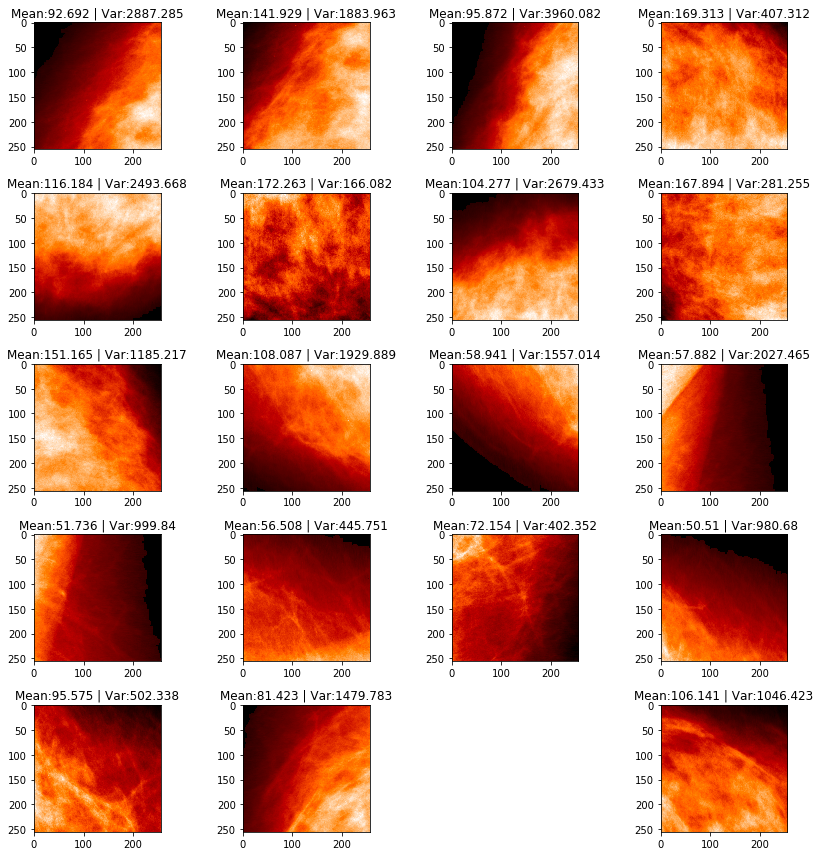

In [18]:
import random
N = 20
idxs = random.sample(range(len(norm07_patches)), k=N)
plt.figure(figsize=(12,12))
for i, idx in enumerate(idxs):
    plt.subplot(5,4,i+1)
    plt.imshow(norm07_patches[i].reshape(256, 256), cmap ='gist_heat')
    plt.title("Mean:" + str(round(np.mean(norm07_patches[i]),3)) + " | Var:" + str(round(np.var(norm07_patches[i]),3)))
    plt.tight_layout() 
plt.show()

In [19]:
#8-bit patch images
norm07_patches = norm07_patches.astype(np.uint8)

In [20]:
np.save(os.path.join("Processed_norm_256", "howtek_patches_norm07.npy"), norm07_patches)
np.save(os.path.join("Processed_norm_256", "howtek_labels_norm07.npy"), norm07_labels)
np.save(os.path.join("Processed_norm_256", "howtek_FileNames_norm07.npy"), norm07_FNs)

In [21]:
#Howteck Normal08
src = 'Normal/Howtek/Normal08/'
norm08_patches, norm08_labels, norm08_FNs = normal_patch_slices(src, upper_thresh=10000, lower_thresh=10, mean_thresh=30, stride=300)

  0%|                                                                                          | 0/108 [00:00<?, ?it/s]

0 - D_4548_1.LEFT_CC.png


  1%|▊                                                                                 | 1/108 [00:00<01:14,  1.44it/s]

111 - D_4548_1.LEFT_MLO.png


  2%|█▌                                                                                | 2/108 [00:01<01:17,  1.37it/s]

127 - D_4548_1.RIGHT_CC.png


  3%|██▎                                                                               | 3/108 [00:02<01:14,  1.41it/s]

127 - D_4548_1.RIGHT_MLO.png


  4%|███                                                                               | 4/108 [00:02<01:13,  1.41it/s]

119 - D_4549_1.LEFT_CC.png


  5%|███▊                                                                              | 5/108 [00:03<01:13,  1.41it/s]

127 - D_4549_1.LEFT_MLO.png


  6%|████▌                                                                             | 6/108 [00:04<01:14,  1.37it/s]

134 - D_4549_1.RIGHT_CC.png


  6%|█████▎                                                                            | 7/108 [00:04<01:10,  1.44it/s]

111 - D_4549_1.RIGHT_MLO.png


  7%|██████                                                                            | 8/108 [00:05<01:10,  1.41it/s]

143 - D_4550_1.LEFT_CC.png


  8%|██████▊                                                                           | 9/108 [00:06<01:23,  1.18it/s]

191 - D_4550_1.LEFT_MLO.png


  9%|███████▌                                                                         | 10/108 [00:08<01:33,  1.04it/s]

175 - D_4550_1.RIGHT_CC.png


 10%|████████▎                                                                        | 11/108 [00:09<01:36,  1.00it/s]

191 - D_4550_1.RIGHT_MLO.png


 11%|█████████                                                                        | 12/108 [00:10<01:38,  1.02s/it]

164 - D_4554_1.LEFT_CC.png


 12%|█████████▊                                                                       | 13/108 [00:10<01:21,  1.16it/s]

97 - D_4554_1.LEFT_MLO.png


 13%|██████████▌                                                                      | 14/108 [00:11<01:14,  1.27it/s]

127 - D_4554_1.RIGHT_CC.png


 14%|███████████▎                                                                     | 15/108 [00:12<01:08,  1.35it/s]

134 - D_4554_1.RIGHT_MLO.png


 15%|████████████                                                                     | 16/108 [00:12<01:06,  1.38it/s]

159 - D_4556_1.LEFT_CC.png


 16%|████████████▊                                                                    | 17/108 [00:13<01:06,  1.37it/s]

134 - D_4556_1.LEFT_MLO.png


 17%|█████████████▌                                                                   | 18/108 [00:14<01:09,  1.29it/s]

143 - D_4556_1.RIGHT_CC.png


 18%|██████████████▎                                                                  | 19/108 [00:15<01:08,  1.29it/s]

134 - D_4556_1.RIGHT_MLO.png


 19%|███████████████                                                                  | 20/108 [00:15<01:10,  1.25it/s]

159 - D_4564_1.LEFT_CC.png


 19%|███████████████▊                                                                 | 21/108 [00:16<01:03,  1.36it/s]

111 - D_4564_1.LEFT_MLO.png


 20%|████████████████▌                                                                | 22/108 [00:17<01:02,  1.39it/s]

119 - D_4564_1.RIGHT_CC.png


 21%|█████████████████▎                                                               | 23/108 [00:17<00:57,  1.47it/s]

119 - D_4564_1.RIGHT_MLO.png


 22%|██████████████████                                                               | 24/108 [00:18<00:58,  1.44it/s]

134 - D_4568_1.LEFT_CC.png


 23%|██████████████████▊                                                              | 25/108 [00:19<00:58,  1.41it/s]

134 - D_4568_1.LEFT_MLO.png


 24%|███████████████████▌                                                             | 26/108 [00:20<01:00,  1.35it/s]

143 - D_4568_1.RIGHT_CC.png


 25%|████████████████████▎                                                            | 27/108 [00:20<01:01,  1.31it/s]

143 - D_4568_1.RIGHT_MLO.png


 26%|█████████████████████                                                            | 28/108 [00:21<01:03,  1.26it/s]

143 - D_4573_1.LEFT_CC.png


 27%|█████████████████████▊                                                           | 29/108 [00:23<01:25,  1.08s/it]

279 - D_4573_1.LEFT_MLO.png


 28%|██████████████████████▌                                                          | 30/108 [00:25<01:41,  1.30s/it]

279 - D_4573_1.RIGHT_CC.png


 29%|███████████████████████▎                                                         | 31/108 [00:26<01:46,  1.39s/it]

259 - D_4573_1.RIGHT_MLO.png


 30%|████████████████████████                                                         | 32/108 [00:28<01:53,  1.49s/it]

279 - D_4578_1.LEFT_CC.png


 31%|████████████████████████▊                                                        | 33/108 [00:29<01:40,  1.34s/it]

179 - D_4578_1.LEFT_MLO.png


 31%|█████████████████████████▌                                                       | 34/108 [00:30<01:33,  1.26s/it]

199 - D_4578_1.RIGHT_CC.png


 32%|██████████████████████████▎                                                      | 35/108 [00:31<01:31,  1.26s/it]

197 - D_4578_1.RIGHT_MLO.png


 33%|███████████████████████████                                                      | 36/108 [00:33<01:32,  1.29s/it]

219 - D_4579_1.LEFT_CC.png


 34%|███████████████████████████▊                                                     | 37/108 [00:34<01:32,  1.31s/it]

239 - D_4579_1.LEFT_MLO.png


 35%|████████████████████████████▌                                                    | 38/108 [00:35<01:31,  1.31s/it]

227 - D_4579_1.RIGHT_CC.png


 36%|█████████████████████████████▎                                                   | 39/108 [00:37<01:31,  1.33s/it]

227 - D_4579_1.RIGHT_MLO.png


 37%|██████████████████████████████                                                   | 40/108 [00:38<01:31,  1.35s/it]

227 - D_4580_1.LEFT_CC.png


 38%|██████████████████████████████▊                                                  | 41/108 [00:39<01:17,  1.15s/it]

119 - D_4580_1.LEFT_MLO.png


 39%|███████████████████████████████▌                                                 | 42/108 [00:40<01:09,  1.05s/it]

143 - D_4580_1.RIGHT_CC.png


 40%|████████████████████████████████▎                                                | 43/108 [00:41<01:04,  1.01it/s]

159 - D_4580_1.RIGHT_MLO.png


 41%|█████████████████████████████████                                                | 44/108 [00:41<01:00,  1.06it/s]

159 - D_4581_1.LEFT_CC.png


 42%|█████████████████████████████████▊                                               | 45/108 [00:42<00:56,  1.12it/s]

143 - D_4581_1.LEFT_MLO.png


 43%|██████████████████████████████████▌                                              | 46/108 [00:43<00:53,  1.15it/s]

143 - D_4581_1.RIGHT_CC.png


 44%|███████████████████████████████████▎                                             | 47/108 [00:44<00:50,  1.22it/s]

143 - D_4581_1.RIGHT_MLO.png


 44%|████████████████████████████████████                                             | 48/108 [00:45<00:48,  1.23it/s]

159 - D_4586_1.LEFT_CC.png


 45%|████████████████████████████████████▊                                            | 49/108 [00:45<00:46,  1.27it/s]

119 - D_4586_1.LEFT_MLO.png


 46%|█████████████████████████████████████▌                                           | 50/108 [00:46<00:45,  1.26it/s]

143 - D_4586_1.RIGHT_CC.png


 47%|██████████████████████████████████████▎                                          | 51/108 [00:47<00:41,  1.39it/s]

97 - D_4586_1.RIGHT_MLO.png


 48%|███████████████████████████████████████                                          | 52/108 [00:47<00:40,  1.38it/s]

143 - D_4596_1.LEFT_CC.png


 49%|███████████████████████████████████████▊                                         | 53/108 [00:48<00:37,  1.47it/s]

97 - D_4596_1.LEFT_MLO.png


 50%|████████████████████████████████████████▌                                        | 54/108 [00:49<00:38,  1.41it/s]

127 - D_4596_1.RIGHT_CC.png


 51%|█████████████████████████████████████████▎                                       | 55/108 [00:49<00:34,  1.53it/s]

97 - D_4596_1.RIGHT_MLO.png


 52%|██████████████████████████████████████████                                       | 56/108 [00:50<00:35,  1.48it/s]

127 - D_4597_1.LEFT_CC.png


 53%|██████████████████████████████████████████▊                                      | 57/108 [00:50<00:32,  1.59it/s]

97 - D_4597_1.LEFT_MLO.png


 54%|███████████████████████████████████████████▌                                     | 58/108 [00:51<00:34,  1.46it/s]

143 - D_4597_1.RIGHT_CC.png


 55%|████████████████████████████████████████████▎                                    | 59/108 [00:52<00:32,  1.50it/s]

111 - D_4597_1.RIGHT_MLO.png


 56%|█████████████████████████████████████████████                                    | 60/108 [00:53<00:31,  1.50it/s]

127 - D_4598_1.LEFT_CC.png


 56%|█████████████████████████████████████████████▋                                   | 61/108 [00:54<00:35,  1.34it/s]

159 - D_4598_1.LEFT_MLO.png


 57%|██████████████████████████████████████████████▌                                  | 62/108 [00:55<00:37,  1.22it/s]

175 - D_4598_1.RIGHT_CC.png


 58%|███████████████████████████████████████████████▎                                 | 63/108 [00:55<00:36,  1.23it/s]

143 - D_4598_1.RIGHT_MLO.png


 59%|████████████████████████████████████████████████                                 | 64/108 [00:56<00:37,  1.18it/s]

175 - D_4599_1.LEFT_CC.png


 60%|████████████████████████████████████████████████▊                                | 65/108 [00:57<00:38,  1.12it/s]

175 - D_4599_1.LEFT_MLO.png


 61%|█████████████████████████████████████████████████▌                               | 66/108 [00:58<00:39,  1.05it/s]

175 - D_4599_1.RIGHT_CC.png


 62%|██████████████████████████████████████████████████▎                              | 67/108 [00:59<00:40,  1.02it/s]

175 - D_4599_1.RIGHT_MLO.png


 63%|███████████████████████████████████████████████████                              | 68/108 [01:01<00:41,  1.03s/it]

175 - D_4600_1.LEFT_CC.png


 64%|███████████████████████████████████████████████████▋                             | 69/108 [01:01<00:39,  1.01s/it]

159 - D_4600_1.LEFT_MLO.png


 65%|████████████████████████████████████████████████████▌                            | 70/108 [01:03<00:40,  1.05s/it]

175 - D_4600_1.RIGHT_CC.png


 66%|█████████████████████████████████████████████████████▎                           | 71/108 [01:04<00:37,  1.01s/it]

159 - D_4600_1.RIGHT_MLO.png


 67%|██████████████████████████████████████████████████████                           | 72/108 [01:05<00:37,  1.04s/it]

175 - D_4601_1.LEFT_CC.png


 68%|██████████████████████████████████████████████████████▊                          | 73/108 [01:06<00:42,  1.22s/it]

259 - D_4601_1.LEFT_MLO.png


 69%|███████████████████████████████████████████████████████▌                         | 74/108 [01:08<00:46,  1.37s/it]

259 - D_4601_1.RIGHT_CC.png


 69%|████████████████████████████████████████████████████████▎                        | 75/108 [01:09<00:45,  1.39s/it]

246 - D_4601_1.RIGHT_MLO.png


 70%|█████████████████████████████████████████████████████████                        | 76/108 [01:11<00:45,  1.42s/it]

233 - D_4602_1.LEFT_CC.png


 71%|█████████████████████████████████████████████████████████▋                       | 77/108 [01:12<00:45,  1.46s/it]

220 - D_4602_1.LEFT_MLO.png


 72%|██████████████████████████████████████████████████████████▌                      | 78/108 [01:14<00:45,  1.51s/it]

251 - D_4602_1.RIGHT_CC.png


 73%|███████████████████████████████████████████████████████████▎                     | 79/108 [01:15<00:42,  1.45s/it]

220 - D_4602_1.RIGHT_MLO.png


 74%|████████████████████████████████████████████████████████████                     | 80/108 [01:17<00:41,  1.50s/it]

279 - D_4603_1.LEFT_CC.png


 75%|████████████████████████████████████████████████████████████▊                    | 81/108 [01:18<00:37,  1.41s/it]

197 - D_4603_1.LEFT_MLO.png


 76%|█████████████████████████████████████████████████████████████▌                   | 82/108 [01:20<00:35,  1.38s/it]

197 - D_4603_1.RIGHT_CC.png


 77%|██████████████████████████████████████████████████████████████▎                  | 83/108 [01:21<00:33,  1.35s/it]

227 - D_4603_1.RIGHT_MLO.png


 78%|███████████████████████████████████████████████████████████████                  | 84/108 [01:22<00:32,  1.36s/it]

227 - D_4604_1.LEFT_CC.png


 79%|███████████████████████████████████████████████████████████████▊                 | 85/108 [01:24<00:31,  1.35s/it]

208 - D_4604_1.LEFT_MLO.png


 80%|████████████████████████████████████████████████████████████████▌                | 86/108 [01:25<00:29,  1.32s/it]

197 - D_4604_1.RIGHT_CC.png


 81%|█████████████████████████████████████████████████████████████████▎               | 87/108 [01:26<00:27,  1.32s/it]

227 - D_4604_1.RIGHT_MLO.png


 81%|██████████████████████████████████████████████████████████████████               | 88/108 [01:27<00:26,  1.31s/it]

208 - D_4605_1.LEFT_CC.png


 82%|██████████████████████████████████████████████████████████████████▊              | 89/108 [01:29<00:25,  1.33s/it]

227 - D_4605_1.LEFT_MLO.png


 83%|███████████████████████████████████████████████████████████████████▌             | 90/108 [01:30<00:24,  1.36s/it]

227 - D_4605_1.RIGHT_CC.png


 84%|████████████████████████████████████████████████████████████████████▎            | 91/108 [01:32<00:23,  1.37s/it]

227 - D_4605_1.RIGHT_MLO.png


 85%|█████████████████████████████████████████████████████████████████████            | 92/108 [01:33<00:23,  1.44s/it]

265 - D_4606_1.LEFT_CC.png


 86%|█████████████████████████████████████████████████████████████████████▊           | 93/108 [01:35<00:21,  1.43s/it]

239 - D_4606_1.LEFT_MLO.png


 87%|██████████████████████████████████████████████████████████████████████▌          | 94/108 [01:36<00:19,  1.38s/it]

208 - D_4606_1.RIGHT_CC.png


 88%|███████████████████████████████████████████████████████████████████████▎         | 95/108 [01:37<00:17,  1.35s/it]

197 - D_4606_1.RIGHT_MLO.png


 89%|████████████████████████████████████████████████████████████████████████         | 96/108 [01:38<00:16,  1.34s/it]

208 - D_4607_1.LEFT_CC.png


 90%|████████████████████████████████████████████████████████████████████████▊        | 97/108 [01:40<00:15,  1.41s/it]

259 - D_4607_1.LEFT_MLO.png


 91%|█████████████████████████████████████████████████████████████████████████▌       | 98/108 [01:42<00:14,  1.44s/it]

233 - D_4607_1.RIGHT_CC.png


 92%|██████████████████████████████████████████████████████████████████████████▎      | 99/108 [01:43<00:13,  1.45s/it]

259 - D_4607_1.RIGHT_MLO.png


 93%|██████████████████████████████████████████████████████████████████████████      | 100/108 [01:45<00:11,  1.47s/it]

246 - D_4608_1.LEFT_CC.png


 94%|██████████████████████████████████████████████████████████████████████████▊     | 101/108 [01:46<00:09,  1.43s/it]

203 - D_4608_1.LEFT_MLO.png


 94%|███████████████████████████████████████████████████████████████████████████▌    | 102/108 [01:47<00:08,  1.42s/it]

227 - D_4608_1.RIGHT_CC.png


 95%|████████████████████████████████████████████████████████████████████████████▎   | 103/108 [01:48<00:06,  1.36s/it]

215 - D_4608_1.RIGHT_MLO.png


 96%|█████████████████████████████████████████████████████████████████████████████   | 104/108 [01:50<00:05,  1.38s/it]

239 - D_4609_1.LEFT_CC.png


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 105/108 [01:51<00:03,  1.29s/it]

179 - D_4609_1.LEFT_MLO.png


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 106/108 [01:52<00:02,  1.32s/it]

219 - D_4609_1.RIGHT_CC.png


 99%|███████████████████████████████████████████████████████████████████████████████▎| 107/108 [01:53<00:01,  1.20s/it]

161 - D_4609_1.RIGHT_MLO.png


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:55<00:00,  1.06s/it]


In [22]:
print("Howtek Normal08 Patches:", len(norm08_patches))
print("Howtek Normal08 Labels:", len(norm08_labels))
print("Howtek Normal08 FileNames:", len(norm08_FNs))

Howtek Normal08 Patches: 7289
Howtek Normal08 Labels: 7289
Howtek Normal08 FileNames: 7289


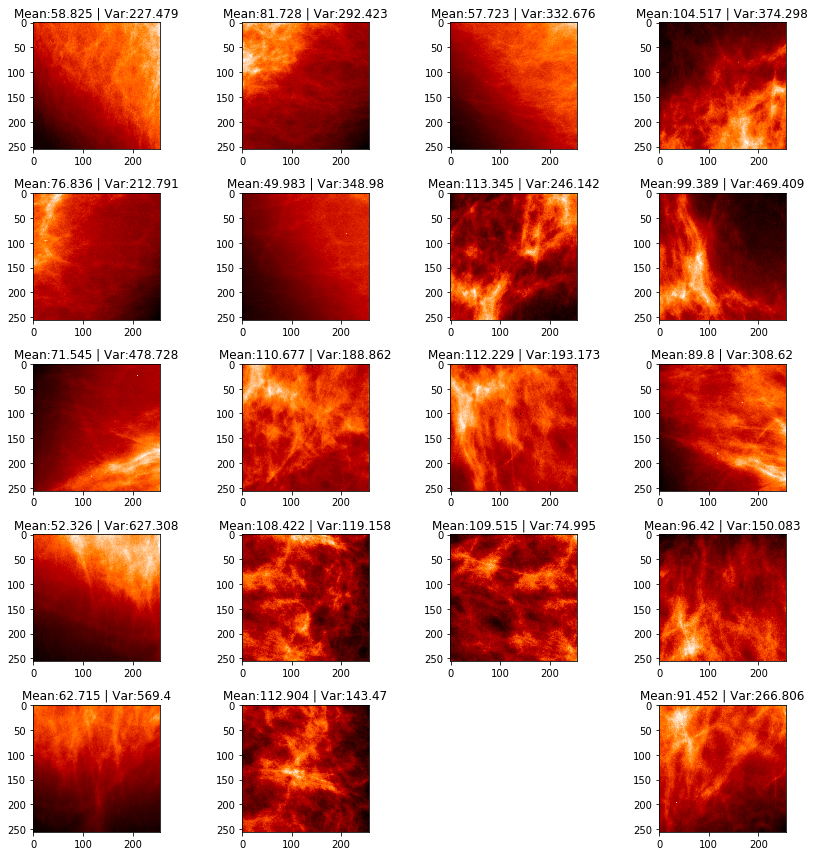

In [23]:
N = 20
idxs = random.sample(range(len(norm08_patches)), k=N)
plt.figure(figsize=(12,12))
for i, idx in enumerate(idxs):
    plt.subplot(5,4,i+1)
    plt.imshow(norm08_patches[i].reshape(256,256), cmap ='gist_heat')
    plt.title("Mean:" + str(round(np.mean(norm08_patches[i]),3)) + " | Var:" + str(round(np.var(norm08_patches[i]),3)))
    plt.tight_layout() 
plt.show()

In [24]:
#8-bit
norm08_patches = norm08_patches.astype(np.uint8)

In [25]:
np.save(os.path.join("Processed_norm_256", "howtek_patches_norm08.npy"), norm08_patches)
np.save(os.path.join("Processed_norm_256", "howtek_labels_norm08.npy"), norm08_labels)
np.save(os.path.join("Processed_norm_256", "howtek_FileNames_norm08.npy"), norm08_FNs)

In [26]:
#Howteck Normal11
src = 'Normal/Howtek/Normal11/'
norm11_patches, norm11_labels, norm11_FNs = normal_patch_slices(src, upper_thresh=10000, lower_thresh=10, mean_thresh=30, stride=350)

  0%|                                                                                          | 0/232 [00:00<?, ?it/s]

0 - A_1955_1.LEFT_CC.png


  0%|▎                                                                                 | 1/232 [00:01<06:14,  1.62s/it]

220 - A_1955_1.LEFT_MLO.png


  1%|▋                                                                                 | 2/232 [00:03<06:14,  1.63s/it]

203 - A_1955_1.RIGHT_CC.png


  1%|█                                                                                 | 3/232 [00:05<06:26,  1.69s/it]

220 - A_1955_1.RIGHT_MLO.png


  2%|█▍                                                                                | 4/232 [00:06<06:11,  1.63s/it]

194 - A_1956_1.LEFT_CC.png


  2%|█▊                                                                                | 5/232 [00:07<05:16,  1.40s/it]

116 - A_1956_1.LEFT_MLO.png


  3%|██                                                                                | 6/232 [00:08<04:31,  1.20s/it]

116 - A_1956_1.RIGHT_CC.png


  3%|██▍                                                                               | 7/232 [00:08<03:59,  1.06s/it]

116 - A_1956_1.RIGHT_MLO.png


  3%|██▊                                                                               | 8/232 [00:09<03:43,  1.00it/s]

125 - A_1957_1.LEFT_CC.png


  4%|███▏                                                                              | 9/232 [00:10<03:21,  1.11it/s]

97 - A_1957_1.LEFT_MLO.png


  4%|███▍                                                                             | 10/232 [00:11<03:07,  1.18it/s]

111 - A_1957_1.RIGHT_CC.png


  5%|███▊                                                                             | 11/232 [00:11<02:53,  1.27it/s]

97 - A_1957_1.RIGHT_MLO.png


  5%|████▏                                                                            | 12/232 [00:12<02:52,  1.27it/s]

97 - A_1958_1.LEFT_CC.png


  6%|████▌                                                                            | 13/232 [00:13<02:57,  1.24it/s]

134 - A_1958_1.LEFT_MLO.png


  6%|████▉                                                                            | 14/232 [00:14<03:22,  1.08it/s]

152 - A_1958_1.RIGHT_CC.png


  6%|█████▏                                                                           | 15/232 [00:15<03:23,  1.07it/s]

134 - A_1958_1.RIGHT_MLO.png


  7%|█████▌                                                                           | 16/232 [00:16<03:35,  1.00it/s]

143 - A_1959_1.LEFT_CC.png


  7%|█████▉                                                                           | 17/232 [00:17<03:49,  1.07s/it]

175 - A_1959_1.LEFT_MLO.png


  8%|██████▎                                                                          | 18/232 [00:19<04:13,  1.18s/it]

175 - A_1959_1.RIGHT_CC.png


  8%|██████▋                                                                          | 19/232 [00:20<04:21,  1.23s/it]

169 - A_1959_1.RIGHT_MLO.png


  9%|██████▉                                                                          | 20/232 [00:22<04:31,  1.28s/it]

175 - A_1960_1.LEFT_CC.png


  9%|███████▎                                                                         | 21/232 [00:23<04:31,  1.29s/it]

159 - A_1960_1.LEFT_MLO.png


  9%|███████▋                                                                         | 22/232 [00:24<04:35,  1.31s/it]

175 - A_1960_1.RIGHT_CC.png


 10%|████████                                                                         | 23/232 [00:26<04:29,  1.29s/it]

159 - A_1960_1.RIGHT_MLO.png


 10%|████████▍                                                                        | 24/232 [00:27<04:36,  1.33s/it]

186 - A_1961_1.LEFT_CC.png


 11%|████████▋                                                                        | 25/232 [00:28<03:46,  1.09s/it]

90 - A_1961_1.LEFT_MLO.png


 11%|█████████                                                                        | 26/232 [00:28<03:21,  1.02it/s]

111 - A_1961_1.RIGHT_CC.png


 12%|█████████▍                                                                       | 27/232 [00:29<02:58,  1.15it/s]

90 - A_1961_1.RIGHT_MLO.png


 12%|█████████▊                                                                       | 28/232 [00:30<02:48,  1.21it/s]

97 - A_1962_1.LEFT_CC.png


 12%|██████████▏                                                                      | 29/232 [00:31<02:53,  1.17it/s]

119 - A_1962_1.LEFT_MLO.png


 13%|██████████▍                                                                      | 30/232 [00:32<03:03,  1.10it/s]

143 - A_1962_1.RIGHT_CC.png


 13%|██████████▊                                                                      | 31/232 [00:33<03:07,  1.07it/s]

143 - A_1962_1.RIGHT_MLO.png


 14%|███████████▏                                                                     | 32/232 [00:34<03:12,  1.04it/s]

127 - A_1963_1.LEFT_CC.png


 14%|███████████▌                                                                     | 33/232 [00:34<02:48,  1.18it/s]

90 - A_1963_1.LEFT_MLO.png


 15%|███████████▊                                                                     | 34/232 [00:35<02:38,  1.25it/s]

97 - A_1963_1.RIGHT_CC.png


 15%|████████████▏                                                                    | 35/232 [00:35<02:14,  1.46it/s]

54 - A_1963_1.RIGHT_MLO.png


 16%|████████████▌                                                                    | 36/232 [00:36<02:09,  1.51it/s]

90 - A_1964_1.LEFT_CC.png


 16%|████████████▉                                                                    | 37/232 [00:37<02:14,  1.45it/s]

125 - A_1964_1.LEFT_MLO.png


 16%|█████████████▎                                                                   | 38/232 [00:38<02:28,  1.30it/s]

139 - A_1964_1.RIGHT_CC.png


 17%|█████████████▌                                                                   | 39/232 [00:38<02:30,  1.29it/s]

111 - A_1964_1.RIGHT_MLO.png


 17%|█████████████▉                                                                   | 40/232 [00:39<02:43,  1.17it/s]

139 - A_1965_1.LEFT_CC.png


 18%|██████████████▎                                                                  | 41/232 [00:40<02:23,  1.33it/s]

77 - A_1965_1.LEFT_MLO.png


 18%|██████████████▋                                                                  | 42/232 [00:41<02:17,  1.39it/s]

97 - A_1965_1.RIGHT_CC.png


 19%|███████████████                                                                  | 43/232 [00:41<02:03,  1.54it/s]

71 - A_1965_1.RIGHT_MLO.png


 19%|███████████████▎                                                                 | 44/232 [00:42<02:02,  1.53it/s]

97 - A_1966_1.LEFT_CC.png


 19%|███████████████▋                                                                 | 45/232 [00:42<02:04,  1.50it/s]

97 - A_1966_1.LEFT_MLO.png


 20%|████████████████                                                                 | 46/232 [00:43<02:15,  1.37it/s]

125 - A_1966_1.RIGHT_CC.png


 20%|████████████████▍                                                                | 47/232 [00:44<02:16,  1.36it/s]

97 - A_1966_1.RIGHT_MLO.png


 21%|████████████████▊                                                                | 48/232 [00:45<02:23,  1.28it/s]

111 - A_1967_1.LEFT_CC.png


 21%|█████████████████                                                                | 49/232 [00:46<02:39,  1.15it/s]

139 - A_1967_1.LEFT_MLO.png


 22%|█████████████████▍                                                               | 50/232 [00:47<02:52,  1.06it/s]

139 - A_1967_1.RIGHT_CC.png


 22%|█████████████████▊                                                               | 51/232 [00:48<02:53,  1.04it/s]

125 - A_1967_1.RIGHT_MLO.png


 22%|██████████████████▏                                                              | 52/232 [00:49<02:51,  1.05it/s]

125 - A_1968_1.LEFT_CC.png


 23%|██████████████████▌                                                              | 53/232 [00:50<02:55,  1.02it/s]

149 - A_1968_1.LEFT_MLO.png


 23%|██████████████████▊                                                              | 54/232 [00:51<03:00,  1.01s/it]

143 - A_1968_1.RIGHT_CC.png


 24%|███████████████████▏                                                             | 55/232 [00:52<03:06,  1.05s/it]

143 - A_1968_1.RIGHT_MLO.png


 24%|███████████████████▌                                                             | 56/232 [00:54<03:16,  1.12s/it]

159 - A_1969_1.LEFT_CC.png


 25%|███████████████████▉                                                             | 57/232 [00:55<03:28,  1.19s/it]

164 - A_1969_1.LEFT_MLO.png


 25%|████████████████████▎                                                            | 58/232 [00:56<03:35,  1.24s/it]

175 - A_1969_1.RIGHT_CC.png


 25%|████████████████████▌                                                            | 59/232 [00:58<03:36,  1.25s/it]

153 - A_1969_1.RIGHT_MLO.png


 26%|████████████████████▉                                                            | 60/232 [00:59<03:39,  1.27s/it]

175 - A_1970_1.LEFT_CC.png


 26%|█████████████████████▎                                                           | 61/232 [00:59<02:57,  1.04s/it]

71 - A_1970_1.LEFT_MLO.png


 27%|█████████████████████▋                                                           | 62/232 [01:00<02:33,  1.11it/s]

77 - A_1970_1.RIGHT_CC.png


 27%|█████████████████████▉                                                           | 63/232 [01:01<02:16,  1.24it/s]

83 - A_1970_1.RIGHT_MLO.png


 28%|██████████████████████▎                                                          | 64/232 [01:01<02:08,  1.31it/s]

90 - A_1971_1.LEFT_CC.png


 28%|██████████████████████▋                                                          | 65/232 [01:02<01:49,  1.53it/s]

59 - A_1971_1.LEFT_MLO.png


 28%|███████████████████████                                                          | 66/232 [01:02<01:38,  1.68it/s]

64 - A_1971_1.RIGHT_CC.png


 29%|███████████████████████▍                                                         | 67/232 [01:03<01:28,  1.86it/s]

59 - A_1971_1.RIGHT_MLO.png


 29%|███████████████████████▋                                                         | 68/232 [01:03<01:21,  2.01it/s]

64 - A_1972_1.LEFT_CC.png


 30%|████████████████████████                                                         | 69/232 [01:04<02:12,  1.23it/s]

203 - A_1972_1.LEFT_MLO.png


 30%|████████████████████████▍                                                        | 70/232 [01:06<02:50,  1.05s/it]

203 - A_1972_1.RIGHT_CC.png


 31%|████████████████████████▊                                                        | 71/232 [01:07<03:05,  1.15s/it]

186 - A_1972_1.RIGHT_MLO.png


 31%|█████████████████████████▏                                                       | 72/232 [01:09<03:25,  1.28s/it]

203 - A_1973_1.LEFT_CC.png


 31%|█████████████████████████▍                                                       | 73/232 [01:10<03:06,  1.17s/it]

125 - A_1973_1.LEFT_MLO.png


 32%|█████████████████████████▊                                                       | 74/232 [01:11<02:56,  1.12s/it]

139 - A_1973_1.RIGHT_CC.png


 32%|██████████████████████████▏                                                      | 75/232 [01:12<02:40,  1.03s/it]

111 - A_1973_1.RIGHT_MLO.png


 33%|██████████████████████████▌                                                      | 76/232 [01:13<02:35,  1.00it/s]

125 - A_1974_1.LEFT_CC.png


 33%|██████████████████████████▉                                                      | 77/232 [01:13<02:11,  1.17it/s]

77 - A_1974_1.LEFT_MLO.png


 34%|███████████████████████████▏                                                     | 78/232 [01:14<01:57,  1.31it/s]

83 - A_1974_1.RIGHT_CC.png


 34%|███████████████████████████▌                                                     | 79/232 [01:14<01:42,  1.49it/s]

77 - A_1974_1.RIGHT_MLO.png


 34%|███████████████████████████▉                                                     | 80/232 [01:15<01:38,  1.54it/s]

83 - A_1975_1.LEFT_CC.png


 35%|████████████████████████████▎                                                    | 81/232 [01:16<01:45,  1.43it/s]

125 - A_1975_1.LEFT_MLO.png


 35%|████████████████████████████▋                                                    | 82/232 [01:17<01:54,  1.31it/s]

125 - A_1975_1.RIGHT_CC.png


 36%|████████████████████████████▉                                                    | 83/232 [01:17<01:52,  1.33it/s]

111 - A_1975_1.RIGHT_MLO.png


 36%|█████████████████████████████▎                                                   | 84/232 [01:18<01:55,  1.28it/s]

111 - A_1976_1.LEFT_CC.png


 37%|█████████████████████████████▋                                                   | 85/232 [01:19<01:42,  1.44it/s]

71 - A_1976_1.LEFT_MLO.png


 37%|██████████████████████████████                                                   | 86/232 [01:19<01:39,  1.47it/s]

97 - A_1976_1.RIGHT_CC.png


 38%|██████████████████████████████▍                                                  | 87/232 [01:20<01:31,  1.58it/s]

71 - A_1976_1.RIGHT_MLO.png


 38%|██████████████████████████████▋                                                  | 88/232 [01:20<01:30,  1.59it/s]

83 - A_1977_1.LEFT_CC.png


 38%|███████████████████████████████                                                  | 89/232 [01:21<01:34,  1.52it/s]

97 - A_1977_1.LEFT_MLO.png


 39%|███████████████████████████████▍                                                 | 90/232 [01:22<01:37,  1.45it/s]

111 - A_1977_1.RIGHT_CC.png


 39%|███████████████████████████████▊                                                 | 91/232 [01:23<01:38,  1.43it/s]

97 - A_1977_1.RIGHT_MLO.png


 40%|████████████████████████████████                                                 | 92/232 [01:23<01:40,  1.39it/s]

97 - A_1978_1.LEFT_CC.png


 40%|████████████████████████████████▍                                                | 93/232 [01:24<01:43,  1.34it/s]

111 - A_1978_1.LEFT_MLO.png


 41%|████████████████████████████████▊                                                | 94/232 [01:25<01:45,  1.30it/s]

111 - A_1978_1.RIGHT_CC.png


 41%|█████████████████████████████████▏                                               | 95/232 [01:26<01:47,  1.28it/s]

111 - A_1978_1.RIGHT_MLO.png


 41%|█████████████████████████████████▌                                               | 96/232 [01:27<01:50,  1.23it/s]

111 - A_1979_1.LEFT_CC.png


 42%|█████████████████████████████████▊                                               | 97/232 [01:28<01:51,  1.21it/s]

116 - A_1979_1.LEFT_MLO.png


 42%|██████████████████████████████████▏                                              | 98/232 [01:29<01:56,  1.15it/s]

116 - A_1979_1.RIGHT_CC.png


 43%|██████████████████████████████████▌                                              | 99/232 [01:29<01:57,  1.13it/s]

103 - A_1979_1.RIGHT_MLO.png


 43%|██████████████████████████████████▍                                             | 100/232 [01:30<01:57,  1.12it/s]

116 - A_1980_1.LEFT_CC.png


 44%|██████████████████████████████████▊                                             | 101/232 [01:31<01:52,  1.17it/s]

111 - A_1980_1.LEFT_MLO.png


 44%|███████████████████████████████████▏                                            | 102/232 [01:32<01:54,  1.13it/s]

125 - A_1980_1.RIGHT_CC.png


 44%|███████████████████████████████████▌                                            | 103/232 [01:33<01:45,  1.22it/s]

90 - A_1980_1.RIGHT_MLO.png


 45%|███████████████████████████████████▊                                            | 104/232 [01:34<01:48,  1.18it/s]

111 - A_1988_1.LEFT_CC.png


 45%|████████████████████████████████████▏                                           | 105/232 [01:34<01:37,  1.30it/s]

97 - A_1988_1.LEFT_MLO.png


 46%|████████████████████████████████████▌                                           | 106/232 [01:35<01:33,  1.35it/s]

97 - A_1988_1.RIGHT_CC.png


 46%|████████████████████████████████████▉                                           | 107/232 [01:35<01:26,  1.44it/s]

77 - A_1988_1.RIGHT_MLO.png


 47%|█████████████████████████████████████▏                                          | 108/232 [01:36<01:28,  1.41it/s]

97 - A_1989_1.LEFT_CC.png


 47%|█████████████████████████████████████▌                                          | 109/232 [01:37<01:17,  1.58it/s]

65 - A_1989_1.LEFT_MLO.png


 47%|█████████████████████████████████████▉                                          | 110/232 [01:37<01:08,  1.77it/s]

64 - A_1989_1.RIGHT_CC.png


 48%|██████████████████████████████████████▎                                         | 111/232 [01:38<01:04,  1.88it/s]

71 - A_1989_1.RIGHT_MLO.png


 48%|██████████████████████████████████████▌                                         | 112/232 [01:38<01:01,  1.95it/s]

64 - A_1990_1.LEFT_CC.png


 49%|██████████████████████████████████████▉                                         | 113/232 [01:39<01:04,  1.85it/s]

97 - A_1990_1.LEFT_MLO.png


 49%|███████████████████████████████████████▎                                        | 114/232 [01:40<01:19,  1.49it/s]

152 - A_1990_1.RIGHT_CC.png


 50%|███████████████████████████████████████▋                                        | 115/232 [01:40<01:24,  1.38it/s]

119 - A_1990_1.RIGHT_MLO.png


 50%|████████████████████████████████████████                                        | 116/232 [01:41<01:33,  1.24it/s]

127 - A_1991_1.LEFT_CC.png


 50%|████████████████████████████████████████▎                                       | 117/232 [01:42<01:25,  1.34it/s]

90 - A_1991_1.LEFT_MLO.png


 51%|████████████████████████████████████████▋                                       | 118/232 [01:43<01:20,  1.42it/s]

90 - A_1991_1.RIGHT_CC.png


 51%|█████████████████████████████████████████                                       | 119/232 [01:43<01:14,  1.52it/s]

83 - A_1991_1.RIGHT_MLO.png


 52%|█████████████████████████████████████████▍                                      | 120/232 [01:44<01:13,  1.53it/s]

77 - A_1992_1.LEFT_CC.png


 52%|█████████████████████████████████████████▋                                      | 121/232 [01:45<01:28,  1.25it/s]

159 - A_1992_1.LEFT_MLO.png


 53%|██████████████████████████████████████████                                      | 122/232 [01:46<01:46,  1.03it/s]

169 - A_1992_1.RIGHT_CC.png


 53%|██████████████████████████████████████████▍                                     | 123/232 [01:48<01:53,  1.04s/it]

159 - A_1992_1.RIGHT_MLO.png


 53%|██████████████████████████████████████████▊                                     | 124/232 [01:49<02:05,  1.16s/it]

186 - A_1993_1.LEFT_CC.png


 54%|███████████████████████████████████████████                                     | 125/232 [01:50<02:05,  1.17s/it]

169 - A_1993_1.LEFT_MLO.png


 54%|███████████████████████████████████████████▍                                    | 126/232 [01:51<02:04,  1.18s/it]

169 - A_1993_1.RIGHT_CC.png


 55%|███████████████████████████████████████████▊                                    | 127/232 [01:53<02:04,  1.18s/it]

169 - A_1993_1.RIGHT_MLO.png


 55%|████████████████████████████████████████████▏                                   | 128/232 [01:54<02:00,  1.16s/it]

143 - A_1994_1.LEFT_CC.png


 56%|████████████████████████████████████████████▍                                   | 129/232 [01:54<01:44,  1.01s/it]

103 - A_1994_1.LEFT_MLO.png


 56%|████████████████████████████████████████████▊                                   | 130/232 [01:55<01:36,  1.06it/s]

111 - A_1994_1.RIGHT_CC.png


 56%|█████████████████████████████████████████████▏                                  | 131/232 [01:56<01:28,  1.14it/s]

103 - A_1994_1.RIGHT_MLO.png


 57%|█████████████████████████████████████████████▌                                  | 132/232 [01:57<01:26,  1.16it/s]

111 - A_1995_1.LEFT_CC.png


 57%|█████████████████████████████████████████████▊                                  | 133/232 [01:58<01:36,  1.03it/s]

159 - A_1995_1.LEFT_MLO.png


 58%|██████████████████████████████████████████████▏                                 | 134/232 [01:59<01:41,  1.04s/it]

159 - A_1995_1.RIGHT_CC.png


 58%|██████████████████████████████████████████████▌                                 | 135/232 [02:01<01:51,  1.15s/it]

186 - A_1995_1.RIGHT_MLO.png


 59%|██████████████████████████████████████████████▉                                 | 136/232 [02:02<02:00,  1.25s/it]

186 - A_1996_1.LEFT_CC.png


 59%|███████████████████████████████████████████████▏                                | 137/232 [02:02<01:34,  1.01it/s]

49 - A_1996_1.LEFT_MLO.png


 59%|███████████████████████████████████████████████▌                                | 138/232 [02:03<01:17,  1.21it/s]

59 - A_1996_1.RIGHT_CC.png


 60%|███████████████████████████████████████████████▉                                | 139/232 [02:03<01:02,  1.49it/s]

35 - A_1996_1.RIGHT_MLO.png


 60%|████████████████████████████████████████████████▎                               | 140/232 [02:04<00:53,  1.71it/s]

54 - A_1997_1.LEFT_CC.png


 61%|████████████████████████████████████████████████▌                               | 141/232 [02:04<00:51,  1.75it/s]

83 - A_1997_1.LEFT_MLO.png


 61%|████████████████████████████████████████████████▉                               | 142/232 [02:05<00:51,  1.76it/s]

77 - A_1997_1.RIGHT_CC.png


 62%|█████████████████████████████████████████████████▎                              | 143/232 [02:05<00:49,  1.81it/s]

69 - A_1997_1.RIGHT_MLO.png


 62%|█████████████████████████████████████████████████▋                              | 144/232 [02:06<00:51,  1.72it/s]

83 - A_1998_1.LEFT_CC.png


 62%|██████████████████████████████████████████████████                              | 145/232 [02:07<00:56,  1.54it/s]

125 - A_1998_1.LEFT_MLO.png


 63%|██████████████████████████████████████████████████▎                             | 146/232 [02:07<01:00,  1.43it/s]

116 - A_1998_1.RIGHT_CC.png


 63%|██████████████████████████████████████████████████▋                             | 147/232 [02:08<01:04,  1.31it/s]

125 - A_1998_1.RIGHT_MLO.png


 64%|███████████████████████████████████████████████████                             | 148/232 [02:09<01:09,  1.22it/s]

129 - A_2002_1.LEFT_CC.png


 64%|███████████████████████████████████████████████████▍                            | 149/232 [02:11<01:22,  1.00it/s]

186 - A_2002_1.LEFT_MLO.png


 65%|███████████████████████████████████████████████████▋                            | 150/232 [02:12<01:33,  1.14s/it]

203 - A_2002_1.RIGHT_CC.png


 65%|████████████████████████████████████████████████████                            | 151/232 [02:14<01:44,  1.29s/it]

203 - A_2002_1.RIGHT_MLO.png


 66%|████████████████████████████████████████████████████▍                           | 152/232 [02:16<01:53,  1.42s/it]

203 - A_2003_1.LEFT_CC.png


 66%|████████████████████████████████████████████████████▊                           | 153/232 [02:17<01:49,  1.39s/it]

186 - A_2003_1.LEFT_MLO.png


 66%|█████████████████████████████████████████████████████                           | 154/232 [02:18<01:49,  1.41s/it]

186 - A_2003_1.RIGHT_CC.png


 67%|█████████████████████████████████████████████████████▍                          | 155/232 [02:20<01:48,  1.41s/it]

186 - A_2003_1.RIGHT_MLO.png


 67%|█████████████████████████████████████████████████████▊                          | 156/232 [02:21<01:49,  1.44s/it]

186 - A_2004_1.LEFT_CC.png


 68%|██████████████████████████████████████████████████████▏                         | 157/232 [02:22<01:40,  1.34s/it]

143 - A_2004_1.LEFT_MLO.png


 68%|██████████████████████████████████████████████████████▍                         | 158/232 [02:24<01:38,  1.33s/it]

169 - A_2004_1.RIGHT_CC.png


 69%|██████████████████████████████████████████████████████▊                         | 159/232 [02:25<01:31,  1.25s/it]

143 - A_2004_1.RIGHT_MLO.png


 69%|███████████████████████████████████████████████████████▏                        | 160/232 [02:26<01:28,  1.23s/it]

159 - A_2005_1.LEFT_CC.png


 69%|███████████████████████████████████████████████████████▌                        | 161/232 [02:27<01:19,  1.11s/it]

135 - A_2005_1.LEFT_MLO.png


 70%|███████████████████████████████████████████████████████▊                        | 162/232 [02:28<01:14,  1.06s/it]

135 - A_2005_1.RIGHT_CC.png


 70%|████████████████████████████████████████████████████████▏                       | 163/232 [02:28<01:08,  1.01it/s]

119 - A_2005_1.RIGHT_MLO.png


 71%|████████████████████████████████████████████████████████▌                       | 164/232 [02:30<01:09,  1.02s/it]

152 - A_2006_1.LEFT_CC.png


 71%|████████████████████████████████████████████████████████▉                       | 165/232 [02:31<01:09,  1.04s/it]

149 - A_2006_1.LEFT_MLO.png


 72%|█████████████████████████████████████████████████████████▏                      | 166/232 [02:32<01:12,  1.09s/it]

159 - A_2006_1.RIGHT_CC.png


 72%|█████████████████████████████████████████████████████████▌                      | 167/232 [02:33<01:10,  1.09s/it]

149 - A_2006_1.RIGHT_MLO.png


 72%|█████████████████████████████████████████████████████████▉                      | 168/232 [02:34<01:14,  1.17s/it]

175 - A_2007_1.LEFT_CC.png


 73%|██████████████████████████████████████████████████████████▎                     | 169/232 [02:35<01:13,  1.16s/it]

159 - A_2007_1.LEFT_MLO.png


 73%|██████████████████████████████████████████████████████████▌                     | 170/232 [02:37<01:14,  1.21s/it]

169 - A_2007_1.RIGHT_CC.png


 74%|██████████████████████████████████████████████████████████▉                     | 171/232 [02:38<01:13,  1.20s/it]

159 - A_2007_1.RIGHT_MLO.png


 74%|███████████████████████████████████████████████████████████▎                    | 172/232 [02:39<01:15,  1.27s/it]

169 - A_2008_1.LEFT_CC.png


 75%|███████████████████████████████████████████████████████████▋                    | 173/232 [02:41<01:14,  1.25s/it]

159 - A_2008_1.LEFT_MLO.png


 75%|████████████████████████████████████████████████████████████                    | 174/232 [02:42<01:14,  1.28s/it]

169 - A_2008_1.RIGHT_CC.png


 75%|████████████████████████████████████████████████████████████▎                   | 175/232 [02:43<01:12,  1.27s/it]

169 - A_2008_1.RIGHT_MLO.png


 76%|████████████████████████████████████████████████████████████▋                   | 176/232 [02:45<01:11,  1.28s/it]

159 - A_2009_1.LEFT_CC.png


 76%|█████████████████████████████████████████████████████████████                   | 177/232 [02:45<01:02,  1.13s/it]

119 - A_2009_1.LEFT_MLO.png


 77%|█████████████████████████████████████████████████████████████▍                  | 178/232 [02:46<00:57,  1.06s/it]

127 - A_2009_1.RIGHT_CC.png


 77%|█████████████████████████████████████████████████████████████▋                  | 179/232 [02:47<00:53,  1.01s/it]

111 - A_2009_1.RIGHT_MLO.png


 78%|██████████████████████████████████████████████████████████████                  | 180/232 [02:48<00:51,  1.00it/s]

127 - A_2010_1.LEFT_CC.png


 78%|██████████████████████████████████████████████████████████████▍                 | 181/232 [02:49<00:45,  1.12it/s]

90 - A_2010_1.LEFT_MLO.png


 78%|██████████████████████████████████████████████████████████████▊                 | 182/232 [02:50<00:43,  1.14it/s]

111 - A_2010_1.RIGHT_CC.png


 79%|███████████████████████████████████████████████████████████████                 | 183/232 [02:50<00:39,  1.23it/s]

97 - A_2010_1.RIGHT_MLO.png


 79%|███████████████████████████████████████████████████████████████▍                | 184/232 [02:51<00:39,  1.23it/s]

111 - A_2011_1.LEFT_CC.png


 80%|███████████████████████████████████████████████████████████████▊                | 185/232 [02:52<00:37,  1.24it/s]

111 - A_2011_1.LEFT_MLO.png


 80%|████████████████████████████████████████████████████████████████▏               | 186/232 [02:53<00:37,  1.23it/s]

111 - A_2011_1.RIGHT_CC.png


 81%|████████████████████████████████████████████████████████████████▍               | 187/232 [02:53<00:35,  1.28it/s]

97 - A_2011_1.RIGHT_MLO.png


 81%|████████████████████████████████████████████████████████████████▊               | 188/232 [02:54<00:34,  1.28it/s]

111 - A_2012_1.LEFT_CC.png


 81%|█████████████████████████████████████████████████████████████████▏              | 189/232 [02:55<00:34,  1.24it/s]

125 - A_2012_1.LEFT_MLO.png


 82%|█████████████████████████████████████████████████████████████████▌              | 190/232 [02:56<00:34,  1.22it/s]

125 - A_2012_1.RIGHT_CC.png


 82%|█████████████████████████████████████████████████████████████████▊              | 191/232 [02:57<00:35,  1.16it/s]

125 - A_2012_1.RIGHT_MLO.png


 83%|██████████████████████████████████████████████████████████████████▏             | 192/232 [02:58<00:35,  1.12it/s]

125 - A_2013_1.LEFT_CC.png


 83%|██████████████████████████████████████████████████████████████████▌             | 193/232 [02:59<00:33,  1.16it/s]

111 - A_2013_1.LEFT_MLO.png


 84%|██████████████████████████████████████████████████████████████████▉             | 194/232 [02:59<00:32,  1.16it/s]

111 - A_2013_1.RIGHT_CC.png


 84%|███████████████████████████████████████████████████████████████████▏            | 195/232 [03:00<00:30,  1.21it/s]

103 - A_2013_1.RIGHT_MLO.png


 84%|███████████████████████████████████████████████████████████████████▌            | 196/232 [03:01<00:29,  1.20it/s]

111 - A_2014_1.LEFT_CC.png


 85%|███████████████████████████████████████████████████████████████████▉            | 197/232 [03:02<00:26,  1.34it/s]

90 - A_2014_1.LEFT_MLO.png


 85%|████████████████████████████████████████████████████████████████████▎           | 198/232 [03:02<00:25,  1.36it/s]

97 - A_2014_1.RIGHT_CC.png


 86%|████████████████████████████████████████████████████████████████████▌           | 199/232 [03:03<00:23,  1.42it/s]

90 - A_2014_1.RIGHT_MLO.png


 86%|████████████████████████████████████████████████████████████████████▉           | 200/232 [03:04<00:22,  1.39it/s]

97 - A_2015_1.LEFT_CC.png


 87%|█████████████████████████████████████████████████████████████████████▎          | 201/232 [03:04<00:19,  1.60it/s]

71 - A_2015_1.LEFT_MLO.png


 87%|█████████████████████████████████████████████████████████████████████▋          | 202/232 [03:05<00:18,  1.63it/s]

77 - A_2015_1.RIGHT_CC.png


 88%|██████████████████████████████████████████████████████████████████████          | 203/232 [03:05<00:16,  1.81it/s]

59 - A_2015_1.RIGHT_MLO.png


 88%|██████████████████████████████████████████████████████████████████████▎         | 204/232 [03:06<00:15,  1.79it/s]

77 - A_2016_1.LEFT_CC.png


 88%|██████████████████████████████████████████████████████████████████████▋         | 205/232 [03:06<00:15,  1.74it/s]

97 - A_2016_1.LEFT_MLO.png


 89%|███████████████████████████████████████████████████████████████████████         | 206/232 [03:07<00:16,  1.60it/s]

97 - A_2016_1.RIGHT_CC.png


 89%|███████████████████████████████████████████████████████████████████████▍        | 207/232 [03:08<00:15,  1.62it/s]

83 - A_2016_1.RIGHT_MLO.png


 90%|███████████████████████████████████████████████████████████████████████▋        | 208/232 [03:08<00:15,  1.57it/s]

97 - A_2017_1.LEFT_CC.png


 90%|████████████████████████████████████████████████████████████████████████        | 209/232 [03:09<00:16,  1.38it/s]

139 - A_2017_1.LEFT_MLO.png


 91%|████████████████████████████████████████████████████████████████████████▍       | 210/232 [03:10<00:17,  1.24it/s]

139 - A_2017_1.RIGHT_CC.png


 91%|████████████████████████████████████████████████████████████████████████▊       | 211/232 [03:11<00:17,  1.20it/s]

125 - A_2017_1.RIGHT_MLO.png


 91%|█████████████████████████████████████████████████████████████████████████       | 212/232 [03:12<00:17,  1.15it/s]

139 - A_2018_1.LEFT_CC.png


 92%|█████████████████████████████████████████████████████████████████████████▍      | 213/232 [03:13<00:14,  1.29it/s]

90 - A_2018_1.LEFT_MLO.png


 92%|█████████████████████████████████████████████████████████████████████████▊      | 214/232 [03:13<00:13,  1.33it/s]

97 - A_2018_1.RIGHT_CC.png


 93%|██████████████████████████████████████████████████████████████████████████▏     | 215/232 [03:14<00:11,  1.43it/s]

77 - A_2018_1.RIGHT_MLO.png


 93%|██████████████████████████████████████████████████████████████████████████▍     | 216/232 [03:15<00:11,  1.41it/s]

97 - A_2019_1.LEFT_CC.png


 94%|██████████████████████████████████████████████████████████████████████████▊     | 217/232 [03:15<00:10,  1.37it/s]

111 - A_2019_1.LEFT_MLO.png


 94%|███████████████████████████████████████████████████████████████████████████▏    | 218/232 [03:16<00:10,  1.33it/s]

111 - A_2019_1.RIGHT_CC.png


 94%|███████████████████████████████████████████████████████████████████████████▌    | 219/232 [03:17<00:09,  1.35it/s]

97 - A_2019_1.RIGHT_MLO.png


 95%|███████████████████████████████████████████████████████████████████████████▊    | 220/232 [03:18<00:09,  1.30it/s]

111 - A_2020_1.LEFT_CC.png


 95%|████████████████████████████████████████████████████████████████████████████▏   | 221/232 [03:18<00:07,  1.43it/s]

77 - A_2020_1.LEFT_MLO.png


 96%|████████████████████████████████████████████████████████████████████████████▌   | 222/232 [03:19<00:06,  1.43it/s]

97 - A_2020_1.RIGHT_CC.png


 96%|████████████████████████████████████████████████████████████████████████████▉   | 223/232 [03:19<00:05,  1.52it/s]

77 - A_2020_1.RIGHT_MLO.png


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 224/232 [03:20<00:05,  1.51it/s]

97 - A_2021_1.LEFT_CC.png


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 225/232 [03:21<00:04,  1.62it/s]

83 - A_2021_1.LEFT_MLO.png


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 226/232 [03:21<00:03,  1.62it/s]

83 - A_2021_1.RIGHT_CC.png


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 227/232 [03:22<00:02,  1.79it/s]

54 - A_2021_1.RIGHT_MLO.png


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 228/232 [03:22<00:02,  1.72it/s]

83 - A_2022_1.LEFT_CC.png


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 229/232 [03:24<00:02,  1.22it/s]

186 - A_2022_1.LEFT_MLO.png


 99%|███████████████████████████████████████████████████████████████████████████████▎| 230/232 [03:25<00:02,  1.01s/it]

203 - A_2022_1.RIGHT_CC.png


100%|███████████████████████████████████████████████████████████████████████████████▋| 231/232 [03:26<00:01,  1.06s/it]

169 - A_2022_1.RIGHT_MLO.png


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [03:28<00:00,  1.11it/s]


In [27]:
print("Howtek Normal11 Patches:", len(norm11_patches))
print("Howtek Normal11 Labels:", len(norm11_labels))
print("Howtek Normal11 File Names:", len(norm11_FNs))

Howtek Normal11 Patches: 11283
Howtek Normal11 Labels: 11283
Howtek Normal11 File Names: 11283


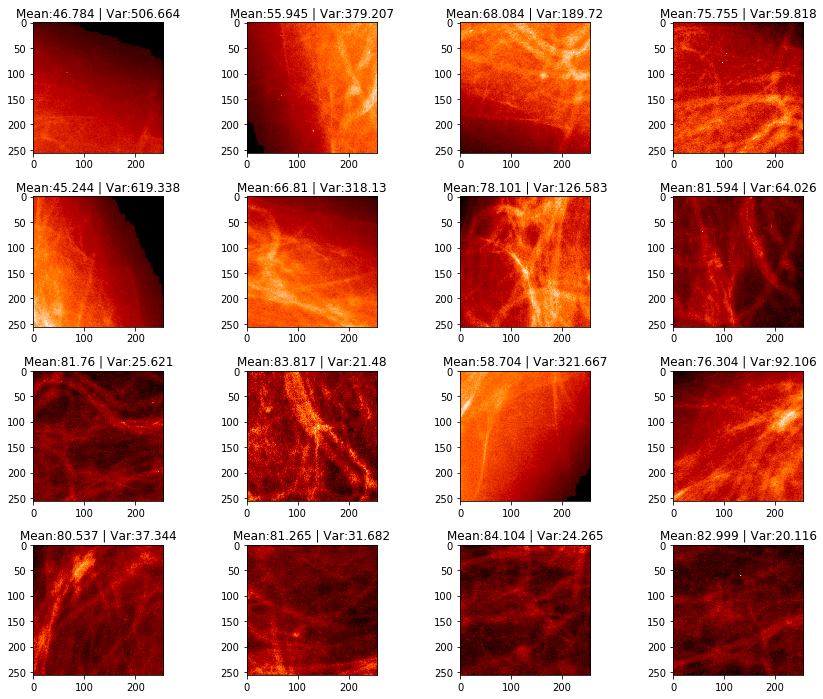

In [28]:
N = 16
idxs = random.sample(range(len(norm11_patches)), k=N)
plt.figure(figsize=(12,12))
for i, idx in enumerate(idxs):
    plt.subplot(5,4,i+1)
    plt.imshow(norm11_patches[i].reshape(256,256), cmap ='gist_heat')
    plt.title("Mean:" + str(round(np.mean(norm11_patches[i]),3)) + " | Var:" + str(round(np.var(norm11_patches[i]),3)))
    plt.tight_layout() 
plt.show()

In [29]:
#8-bit images
norm11_patches = norm11_patches.astype(np.uint8)

In [30]:
np.save(os.path.join("Processed_norm_256", "howtek_patches_norm11.npy"), norm11_patches)
np.save(os.path.join("Processed_norm_256", "howtek_labels_norm11.npy"), norm11_labels)
np.save(os.path.join("Processed_norm_256", "howtek_FileNames_norm08.npy"), norm11_FNs)

In [31]:
#Howteck Normal12
src = 'Normal/Howtek/Normal12/'
norm12_patches, norm12_labels, norm12_FNs = normal_patch_slices(src, upper_thresh=10000, lower_thresh=10, mean_thresh=30, stride=300)

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]

0 - A_2023_1.LEFT_CC.png


  1%|█                                                                                  | 1/80 [00:01<02:03,  1.57s/it]

259 - A_2023_1.LEFT_MLO.png


  2%|██                                                                                 | 2/80 [00:03<02:06,  1.62s/it]

279 - A_2023_1.RIGHT_CC.png


  4%|███                                                                                | 3/80 [00:04<02:05,  1.62s/it]

259 - A_2023_1.RIGHT_MLO.png


  5%|████▏                                                                              | 4/80 [00:06<02:07,  1.68s/it]

279 - A_2024_1.LEFT_CC.png


  6%|█████▏                                                                             | 5/80 [00:07<01:50,  1.47s/it]

169 - A_2024_1.LEFT_MLO.png


  8%|██████▏                                                                            | 6/80 [00:08<01:42,  1.39s/it]

189 - A_2024_1.RIGHT_CC.png


  9%|███████▎                                                                           | 7/80 [00:09<01:33,  1.29s/it]

169 - A_2024_1.RIGHT_MLO.png


 10%|████████▎                                                                          | 8/80 [00:11<01:30,  1.26s/it]

179 - A_2026_1.LEFT_CC.png


 11%|█████████▎                                                                         | 9/80 [00:12<01:30,  1.27s/it]

219 - A_2026_1.LEFT_MLO.png


 12%|██████████▎                                                                       | 10/80 [00:13<01:26,  1.24s/it]

219 - A_2026_1.RIGHT_CC.png


 14%|███████████▎                                                                      | 11/80 [00:14<01:26,  1.25s/it]

208 - A_2026_1.RIGHT_MLO.png


 15%|████████████▎                                                                     | 12/80 [00:16<01:23,  1.23s/it]

208 - A_2027_1.LEFT_CC.png


 16%|█████████████▎                                                                    | 13/80 [00:17<01:27,  1.31s/it]

246 - A_2027_1.LEFT_MLO.png


 18%|██████████████▎                                                                   | 14/80 [00:19<01:30,  1.37s/it]

251 - A_2027_1.RIGHT_CC.png


 19%|███████████████▍                                                                  | 15/80 [00:20<01:30,  1.39s/it]

233 - A_2027_1.RIGHT_MLO.png


 20%|████████████████▍                                                                 | 16/80 [00:22<01:33,  1.47s/it]

265 - A_2028_1.LEFT_CC.png


 21%|█████████████████▍                                                                | 17/80 [00:23<01:30,  1.43s/it]

239 - A_2028_1.LEFT_MLO.png


 22%|██████████████████▍                                                               | 18/80 [00:24<01:26,  1.40s/it]

227 - A_2028_1.RIGHT_CC.png


 24%|███████████████████▍                                                              | 19/80 [00:26<01:21,  1.34s/it]

175 - A_2028_1.RIGHT_MLO.png


 25%|████████████████████▌                                                             | 20/80 [00:27<01:23,  1.39s/it]

239 - A_2029_1.LEFT_CC.png


 26%|█████████████████████▌                                                            | 21/80 [00:28<01:14,  1.27s/it]

179 - A_2029_1.LEFT_MLO.png


 28%|██████████████████████▌                                                           | 22/80 [00:29<01:13,  1.28s/it]

219 - A_2029_1.RIGHT_CC.png


 29%|███████████████████████▌                                                          | 23/80 [00:30<01:08,  1.20s/it]

179 - A_2029_1.RIGHT_MLO.png


 30%|████████████████████████▌                                                         | 24/80 [00:32<01:06,  1.19s/it]

179 - A_2030_1.LEFT_CC.png


 31%|█████████████████████████▋                                                        | 25/80 [00:33<01:06,  1.21s/it]

215 - A_2030_1.LEFT_MLO.png


 32%|██████████████████████████▋                                                       | 26/80 [00:34<01:11,  1.32s/it]

239 - A_2030_1.RIGHT_CC.png


 34%|███████████████████████████▋                                                      | 27/80 [00:36<01:14,  1.40s/it]

259 - A_2030_1.RIGHT_MLO.png


 35%|████████████████████████████▋                                                     | 28/80 [00:38<01:16,  1.47s/it]

246 - A_2031_1.LEFT_CC.png


 36%|█████████████████████████████▋                                                    | 29/80 [00:39<01:19,  1.55s/it]

279 - A_2031_1.LEFT_MLO.png


 38%|██████████████████████████████▊                                                   | 30/80 [00:41<01:19,  1.59s/it]

265 - A_2031_1.RIGHT_CC.png


 39%|███████████████████████████████▊                                                  | 31/80 [00:43<01:19,  1.62s/it]

265 - A_2031_1.RIGHT_MLO.png


 40%|████████████████████████████████▊                                                 | 32/80 [00:45<01:21,  1.70s/it]

259 - A_2032_1.LEFT_CC.png


 41%|█████████████████████████████████▊                                                | 33/80 [00:46<01:12,  1.54s/it]

208 - A_2032_1.LEFT_MLO.png


 42%|██████████████████████████████████▊                                               | 34/80 [00:47<01:08,  1.50s/it]

239 - A_2032_1.RIGHT_CC.png


 44%|███████████████████████████████████▉                                              | 35/80 [00:48<01:01,  1.37s/it]

161 - A_2032_1.RIGHT_MLO.png


 45%|████████████████████████████████████▉                                             | 36/80 [00:50<01:00,  1.37s/it]

208 - A_2033_1.LEFT_CC.png


 46%|█████████████████████████████████████▉                                            | 37/80 [00:51<00:55,  1.29s/it]

167 - A_2033_1.LEFT_MLO.png


 48%|██████████████████████████████████████▉                                           | 38/80 [00:52<00:53,  1.27s/it]

191 - A_2033_1.RIGHT_CC.png


 49%|███████████████████████████████████████▉                                          | 39/80 [00:53<00:50,  1.24s/it]

175 - A_2033_1.RIGHT_MLO.png


 50%|█████████████████████████████████████████                                         | 40/80 [00:54<00:50,  1.25s/it]

191 - A_2034_1.LEFT_CC.png


 51%|██████████████████████████████████████████                                        | 41/80 [00:55<00:42,  1.09s/it]

127 - A_2034_1.LEFT_MLO.png


 52%|███████████████████████████████████████████                                       | 42/80 [00:56<00:38,  1.02s/it]

143 - A_2034_1.RIGHT_CC.png


 54%|████████████████████████████████████████████                                      | 43/80 [00:57<00:33,  1.11it/s]

104 - A_2034_1.RIGHT_MLO.png


 55%|█████████████████████████████████████████████                                     | 44/80 [00:57<00:31,  1.13it/s]

143 - A_2035_1.LEFT_CC.png


 56%|██████████████████████████████████████████████▏                                   | 45/80 [00:58<00:28,  1.22it/s]

127 - A_2035_1.LEFT_MLO.png


 57%|███████████████████████████████████████████████▏                                  | 46/80 [00:59<00:27,  1.24it/s]

143 - A_2035_1.RIGHT_CC.png


 59%|████████████████████████████████████████████████▏                                 | 47/80 [00:59<00:24,  1.35it/s]

104 - A_2035_1.RIGHT_MLO.png


 60%|█████████████████████████████████████████████████▏                                | 48/80 [01:00<00:23,  1.35it/s]

127 - A_2036_1.LEFT_CC.png


 61%|██████████████████████████████████████████████████▏                               | 49/80 [01:01<00:22,  1.37it/s]

119 - A_2036_1.LEFT_MLO.png


 62%|███████████████████████████████████████████████████▎                              | 50/80 [01:02<00:22,  1.31it/s]

143 - A_2036_1.RIGHT_CC.png


 64%|████████████████████████████████████████████████████▎                             | 51/80 [01:02<00:21,  1.34it/s]

119 - A_2036_1.RIGHT_MLO.png


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [01:03<00:20,  1.34it/s]

127 - A_2037_1.LEFT_CC.png


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [01:04<00:23,  1.14it/s]

208 - A_2037_1.LEFT_MLO.png


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [01:06<00:27,  1.04s/it]

197 - A_2037_1.RIGHT_CC.png


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [01:07<00:26,  1.06s/it]

179 - A_2037_1.RIGHT_MLO.png


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [01:08<00:25,  1.08s/it]

169 - A_2038_1.LEFT_CC.png


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [01:09<00:26,  1.13s/it]

239 - A_2038_1.LEFT_MLO.png


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [01:11<00:27,  1.24s/it]

259 - A_2038_1.RIGHT_CC.png


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [01:12<00:26,  1.26s/it]

239 - A_2038_1.RIGHT_MLO.png


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [01:13<00:25,  1.29s/it]

227 - A_2039_1.LEFT_CC.png


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [01:15<00:24,  1.27s/it]

208 - A_2039_1.LEFT_MLO.png


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [01:16<00:23,  1.29s/it]

239 - A_2039_1.RIGHT_CC.png


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [01:17<00:21,  1.24s/it]

179 - A_2039_1.RIGHT_MLO.png


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [01:18<00:19,  1.21s/it]

189 - A_2040_1.LEFT_CC.png


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [01:19<00:15,  1.02s/it]

111 - A_2040_1.LEFT_MLO.png


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [01:20<00:13,  1.07it/s]

134 - A_2040_1.RIGHT_CC.png


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [01:20<00:11,  1.17it/s]

127 - A_2040_1.RIGHT_MLO.png


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [01:21<00:09,  1.24it/s]

127 - A_2041_1.LEFT_CC.png


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [01:22<00:08,  1.32it/s]

127 - A_2041_1.LEFT_MLO.png


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [01:22<00:07,  1.36it/s]

127 - A_2041_1.RIGHT_CC.png


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [01:23<00:06,  1.43it/s]

119 - A_2041_1.RIGHT_MLO.png


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [01:24<00:05,  1.40it/s]

127 - A_2042_1.LEFT_CC.png


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [01:25<00:05,  1.25it/s]

161 - A_2042_1.LEFT_MLO.png


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [01:26<00:05,  1.11it/s]

199 - A_2042_1.RIGHT_CC.png


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [01:27<00:04,  1.09it/s]

152 - A_2042_1.RIGHT_MLO.png


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [01:28<00:03,  1.04it/s]

179 - A_2043_1.LEFT_CC.png


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [01:29<00:03,  1.03s/it]

197 - A_2043_1.LEFT_MLO.png


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [01:30<00:02,  1.07s/it]

208 - A_2043_1.RIGHT_CC.png


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [01:31<00:01,  1.09s/it]

169 - A_2043_1.RIGHT_MLO.png


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:32<00:00,  1.16s/it]


In [32]:
print("Howtek Normal12 Patches:", len(norm12_patches))
print("Howtek Normal12 Labels:", len(norm12_labels))
print("Howtek Normal12 Labels:", len(norm12_FNs))

Howtek Normal12 Patches: 5823
Howtek Normal12 Labels: 5823
Howtek Normal12 Labels: 5823


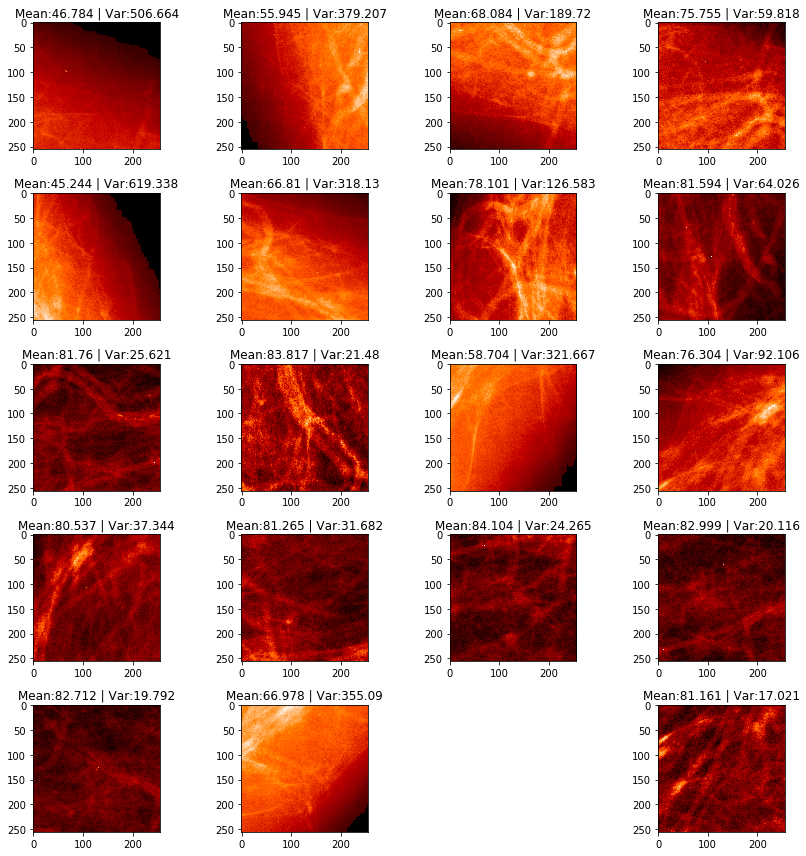

In [33]:
N = 20
idxs = random.sample(range(len(norm11_patches)), k=N)
plt.figure(figsize=(12,12))
for i, idx in enumerate(idxs):
    plt.subplot(5,4,i+1)
    plt.imshow(norm11_patches[i].reshape(256, 256), cmap ='gist_heat')
    plt.title("Mean:" + str(round(np.mean(norm11_patches[i]),3)) + " | Var:" + str(round(np.var(norm11_patches[i]),3)))
    plt.tight_layout() 
plt.show()

In [34]:
#8-bit images
norm12_patches = norm12_patches.astype(np.uint8)

In [35]:
np.save(os.path.join("Processed_norm_256", "howtek_patches_norm12.npy"), norm12_patches)
np.save(os.path.join("Processed_norm_256", "howtek_labels_norm12.npy"), norm12_labels)
np.save(os.path.join("Processed_norm_256", "howtek_labels_norm12.npy"), norm12_FNs)

**Merge Howtek**

In [36]:
howtek_patches = np.concatenate([norm07_patches, norm08_patches, norm11_patches, norm12_patches], axis = 0)
howtek_labels = np.concatenate([norm07_labels, norm08_labels, norm11_labels, norm12_labels], axis = 0)
howtek_FNs = np.concatenate([norm07_FNs, norm08_FNs, norm11_FNs, norm12_FNs], axis = 0)

In [37]:
np.save(os.path.join("Processed_norm_256", "howtek_patches_all.npy"), howtek_patches)
np.save(os.path.join("Processed_norm_256", "howtek_labels_all.npy"), howtek_labels)
np.save(os.path.join("Processed_norm_256", "howtek_FileNames_all.npy"), howtek_FNs)

## Lumisys Patches

In [38]:
#Lumisys Normal09
src = 'Normal/Lumisys/Normal09/'
norm09_patches, norm09_labels, norm09_FNs = normal_patch_slices(src, upper_thresh=10000, lower_thresh=10, mean_thresh=28, stride=300)

  0%|                                                                                          | 0/236 [00:00<?, ?it/s]

0 - B_3600_1.LEFT_CC.png


  0%|▎                                                                                 | 1/236 [00:00<02:26,  1.60it/s]

125 - B_3600_1.LEFT_MLO.png


  1%|▋                                                                                 | 2/236 [00:01<02:31,  1.54it/s]

125 - B_3600_1.RIGHT_CC.png


  1%|█                                                                                 | 3/236 [00:01<02:27,  1.58it/s]

125 - B_3600_1.RIGHT_MLO.png


  2%|█▍                                                                                | 4/236 [00:02<02:27,  1.57it/s]

125 - B_3601_1.LEFT_CC.png


  2%|█▋                                                                                | 5/236 [00:03<02:32,  1.51it/s]

125 - B_3601_1.LEFT_MLO.png


  3%|██                                                                                | 6/236 [00:04<02:38,  1.46it/s]

125 - B_3601_1.RIGHT_CC.png


  3%|██▍                                                                               | 7/236 [00:04<02:36,  1.46it/s]

125 - B_3601_1.RIGHT_MLO.png


  3%|██▊                                                                               | 8/236 [00:05<02:38,  1.44it/s]

125 - B_3602_1.LEFT_CC.png


  4%|███▏                                                                              | 9/236 [00:06<02:39,  1.43it/s]

125 - B_3602_1.LEFT_MLO.png


  4%|███▍                                                                             | 10/236 [00:07<02:48,  1.34it/s]

125 - B_3602_1.RIGHT_CC.png


  5%|███▊                                                                             | 11/236 [00:07<02:43,  1.37it/s]

125 - B_3602_1.RIGHT_MLO.png


  5%|████                                                                             | 12/236 [00:08<02:46,  1.34it/s]

125 - B_3603_1.LEFT_CC.png


  6%|████▍                                                                            | 13/236 [00:09<02:44,  1.35it/s]

125 - B_3603_1.LEFT_MLO.png


  6%|████▊                                                                            | 14/236 [00:09<02:47,  1.32it/s]

125 - B_3603_1.RIGHT_CC.png


  6%|█████▏                                                                           | 15/236 [00:10<02:44,  1.34it/s]

125 - B_3603_1.RIGHT_MLO.png


  7%|█████▍                                                                           | 16/236 [00:11<02:43,  1.35it/s]

125 - B_3604_1.LEFT_CC.png


  7%|█████▊                                                                           | 17/236 [00:12<02:59,  1.22it/s]

139 - B_3604_1.LEFT_MLO.png


  8%|██████▏                                                                          | 18/236 [00:13<03:31,  1.03it/s]

203 - B_3604_1.RIGHT_CC.png


  8%|██████▌                                                                          | 19/236 [00:14<03:26,  1.05it/s]

139 - B_3604_1.RIGHT_MLO.png


  8%|██████▊                                                                          | 20/236 [00:15<03:44,  1.04s/it]

203 - B_3605_1.LEFT_CC.png


  9%|███████▏                                                                         | 21/236 [00:16<03:19,  1.08it/s]

125 - B_3605_1.LEFT_MLO.png


  9%|███████▌                                                                         | 22/236 [00:17<03:04,  1.16it/s]

125 - B_3605_1.RIGHT_CC.png


 10%|███████▉                                                                         | 23/236 [00:17<02:49,  1.26it/s]

125 - B_3605_1.RIGHT_MLO.png


 10%|████████▏                                                                        | 24/236 [00:18<02:42,  1.31it/s]

125 - B_3606_1.LEFT_CC.png


 11%|████████▌                                                                        | 25/236 [00:19<02:53,  1.22it/s]

139 - B_3606_1.LEFT_MLO.png


 11%|████████▉                                                                        | 26/236 [00:20<03:07,  1.12it/s]

139 - B_3606_1.RIGHT_CC.png


 11%|█████████▎                                                                       | 27/236 [00:21<03:02,  1.15it/s]

139 - B_3606_1.RIGHT_MLO.png


 12%|█████████▌                                                                       | 28/236 [00:22<03:05,  1.12it/s]

139 - B_3607_1.LEFT_CC.png


 12%|█████████▉                                                                       | 29/236 [00:23<02:51,  1.21it/s]

125 - B_3607_1.LEFT_MLO.png


 13%|██████████▎                                                                      | 30/236 [00:23<02:41,  1.27it/s]

125 - B_3607_1.RIGHT_CC.png


 13%|██████████▋                                                                      | 31/236 [00:24<02:31,  1.35it/s]

125 - B_3607_1.RIGHT_MLO.png


 14%|██████████▉                                                                      | 32/236 [00:25<02:26,  1.39it/s]

125 - B_3608_1.LEFT_CC.png


 14%|███████████▎                                                                     | 33/236 [00:25<02:28,  1.36it/s]

125 - B_3608_1.LEFT_MLO.png


 14%|███████████▋                                                                     | 34/236 [00:26<02:31,  1.34it/s]

125 - B_3608_1.RIGHT_CC.png


 15%|████████████                                                                     | 35/236 [00:27<02:27,  1.37it/s]

125 - B_3608_1.RIGHT_MLO.png


 15%|████████████▎                                                                    | 36/236 [00:28<02:26,  1.36it/s]

125 - B_3609_1.LEFT_CC.png


 16%|████████████▋                                                                    | 37/236 [00:28<02:23,  1.39it/s]

125 - B_3609_1.LEFT_MLO.png


 16%|█████████████                                                                    | 38/236 [00:29<02:22,  1.39it/s]

125 - B_3609_1.RIGHT_CC.png


 17%|█████████████▍                                                                   | 39/236 [00:30<02:19,  1.41it/s]

125 - B_3609_1.RIGHT_MLO.png


 17%|█████████████▋                                                                   | 40/236 [00:30<02:17,  1.43it/s]

125 - B_3610_1.LEFT_CC.png


 17%|██████████████                                                                   | 41/236 [00:31<02:12,  1.47it/s]

125 - B_3610_1.LEFT_MLO.png


 18%|██████████████▍                                                                  | 42/236 [00:32<02:12,  1.47it/s]

125 - B_3610_1.RIGHT_CC.png


 18%|██████████████▊                                                                  | 43/236 [00:32<02:06,  1.53it/s]

125 - B_3610_1.RIGHT_MLO.png


 19%|███████████████                                                                  | 44/236 [00:33<02:02,  1.56it/s]

125 - B_3611_1.LEFT_CC.png


 19%|███████████████▍                                                                 | 45/236 [00:34<02:03,  1.54it/s]

125 - B_3611_1.LEFT_MLO.png


 19%|███████████████▊                                                                 | 46/236 [00:34<02:03,  1.54it/s]

125 - B_3611_1.RIGHT_CC.png


 20%|████████████████▏                                                                | 47/236 [00:35<02:00,  1.57it/s]

125 - B_3611_1.RIGHT_MLO.png


 20%|████████████████▍                                                                | 48/236 [00:35<02:00,  1.57it/s]

125 - B_3612_1.LEFT_CC.png


 21%|████████████████▊                                                                | 49/236 [00:36<02:01,  1.54it/s]

125 - B_3612_1.LEFT_MLO.png


 21%|█████████████████▏                                                               | 50/236 [00:37<02:02,  1.52it/s]

125 - B_3612_1.RIGHT_CC.png


 22%|█████████████████▌                                                               | 51/236 [00:37<02:01,  1.52it/s]

125 - B_3612_1.RIGHT_MLO.png


 22%|█████████████████▊                                                               | 52/236 [00:38<02:03,  1.49it/s]

125 - B_3613_1.LEFT_CC.png


 22%|██████████████████▏                                                              | 53/236 [00:39<02:39,  1.15it/s]

203 - B_3613_1.LEFT_MLO.png


 23%|██████████████████▌                                                              | 54/236 [00:41<03:07,  1.03s/it]

203 - B_3613_1.RIGHT_CC.png


 23%|██████████████████▉                                                              | 55/236 [00:42<03:26,  1.14s/it]

215 - B_3613_1.RIGHT_MLO.png


 24%|███████████████████▏                                                             | 56/236 [00:44<03:46,  1.26s/it]

215 - B_3614_1.LEFT_CC.png


 24%|███████████████████▌                                                             | 57/236 [00:44<03:10,  1.07s/it]

125 - B_3614_1.LEFT_MLO.png


 25%|███████████████████▉                                                             | 58/236 [00:45<02:46,  1.07it/s]

125 - B_3614_1.RIGHT_CC.png


 25%|████████████████████▎                                                            | 59/236 [00:46<02:27,  1.20it/s]

125 - B_3614_1.RIGHT_MLO.png


 25%|████████████████████▌                                                            | 60/236 [00:46<02:15,  1.30it/s]

125 - B_3615_1.LEFT_CC.png


 26%|████████████████████▉                                                            | 61/236 [00:48<02:43,  1.07it/s]

215 - B_3615_1.LEFT_MLO.png


 26%|█████████████████████▎                                                           | 62/236 [00:49<03:19,  1.14s/it]

203 - B_3615_1.RIGHT_CC.png


 27%|█████████████████████▌                                                           | 63/236 [00:51<03:30,  1.22s/it]

203 - B_3615_1.RIGHT_MLO.png


 27%|█████████████████████▉                                                           | 64/236 [00:52<03:42,  1.29s/it]

203 - B_3616_1.LEFT_CC.png


 28%|██████████████████████▎                                                          | 65/236 [00:53<03:06,  1.09s/it]

125 - B_3616_1.LEFT_MLO.png


 28%|██████████████████████▋                                                          | 66/236 [00:53<02:43,  1.04it/s]

125 - B_3616_1.RIGHT_CC.png


 28%|██████████████████████▉                                                          | 67/236 [00:54<02:25,  1.16it/s]

125 - B_3616_1.RIGHT_MLO.png


 29%|███████████████████████▎                                                         | 68/236 [00:55<02:12,  1.27it/s]

125 - B_3617_1.LEFT_CC.png


 29%|███████████████████████▋                                                         | 69/236 [00:55<02:03,  1.35it/s]

125 - B_3617_1.LEFT_MLO.png


 30%|████████████████████████                                                         | 70/236 [00:56<01:59,  1.39it/s]

125 - B_3617_1.RIGHT_CC.png


 30%|████████████████████████▎                                                        | 71/236 [00:57<01:53,  1.46it/s]

125 - B_3617_1.RIGHT_MLO.png


 31%|████████████████████████▋                                                        | 72/236 [00:57<01:49,  1.49it/s]

125 - B_3618_1.LEFT_CC.png


 31%|█████████████████████████                                                        | 73/236 [00:58<02:22,  1.15it/s]

203 - B_3618_1.LEFT_MLO.png


 31%|█████████████████████████▍                                                       | 74/236 [01:00<02:45,  1.02s/it]

203 - B_3618_1.RIGHT_CC.png


 32%|█████████████████████████▋                                                       | 75/236 [01:01<02:53,  1.08s/it]

203 - B_3618_1.RIGHT_MLO.png


 32%|██████████████████████████                                                       | 76/236 [01:02<03:02,  1.14s/it]

203 - B_3619_1.LEFT_CC.png


 33%|██████████████████████████▍                                                      | 77/236 [01:03<02:37,  1.01it/s]

125 - B_3619_1.LEFT_MLO.png


 33%|██████████████████████████▊                                                      | 78/236 [01:04<02:21,  1.12it/s]

125 - B_3619_1.RIGHT_CC.png


 33%|███████████████████████████                                                      | 79/236 [01:04<02:06,  1.24it/s]

125 - B_3619_1.RIGHT_MLO.png


 34%|███████████████████████████▍                                                     | 80/236 [01:05<02:00,  1.30it/s]

125 - B_3620_1.LEFT_CC.png


 34%|███████████████████████████▊                                                     | 81/236 [01:06<01:53,  1.36it/s]

125 - B_3620_1.LEFT_MLO.png


 35%|████████████████████████████▏                                                    | 82/236 [01:06<01:51,  1.38it/s]

125 - B_3620_1.RIGHT_CC.png


 35%|████████████████████████████▍                                                    | 83/236 [01:07<01:46,  1.44it/s]

125 - B_3620_1.RIGHT_MLO.png


 36%|████████████████████████████▊                                                    | 84/236 [01:08<01:43,  1.46it/s]

125 - B_3621_1.LEFT_CC.png


 36%|█████████████████████████████▏                                                   | 85/236 [01:09<02:15,  1.11it/s]

203 - B_3621_1.LEFT_MLO.png


 36%|█████████████████████████████▌                                                   | 86/236 [01:10<02:40,  1.07s/it]

203 - B_3621_1.RIGHT_CC.png


 37%|█████████████████████████████▊                                                   | 87/236 [01:12<02:50,  1.15s/it]

203 - B_3621_1.RIGHT_MLO.png


 37%|██████████████████████████████▏                                                  | 88/236 [01:13<03:00,  1.22s/it]

203 - B_3622_1.LEFT_CC.png


 38%|██████████████████████████████▌                                                  | 89/236 [01:14<02:37,  1.07s/it]

125 - B_3622_1.LEFT_MLO.png


 38%|██████████████████████████████▉                                                  | 90/236 [01:15<02:19,  1.05it/s]

125 - B_3622_1.RIGHT_CC.png


 39%|███████████████████████████████▏                                                 | 91/236 [01:15<02:05,  1.16it/s]

125 - B_3622_1.RIGHT_MLO.png


 39%|███████████████████████████████▌                                                 | 92/236 [01:16<01:56,  1.23it/s]

125 - B_3623_1.LEFT_CC.png


 39%|███████████████████████████████▉                                                 | 93/236 [01:17<01:49,  1.30it/s]

125 - B_3623_1.LEFT_MLO.png


 40%|████████████████████████████████▎                                                | 94/236 [01:17<01:48,  1.31it/s]

125 - B_3623_1.RIGHT_CC.png


 40%|████████████████████████████████▌                                                | 95/236 [01:18<01:43,  1.36it/s]

125 - B_3623_1.RIGHT_MLO.png


 41%|████████████████████████████████▉                                                | 96/236 [01:19<01:47,  1.31it/s]

125 - B_3624_1.LEFT_CC.png


 41%|█████████████████████████████████▎                                               | 97/236 [01:20<01:48,  1.28it/s]

139 - B_3624_1.LEFT_MLO.png


 42%|█████████████████████████████████▋                                               | 98/236 [01:21<01:51,  1.24it/s]

125 - B_3624_1.RIGHT_CC.png


 42%|█████████████████████████████████▉                                               | 99/236 [01:21<01:49,  1.26it/s]

125 - B_3624_1.RIGHT_MLO.png


 42%|█████████████████████████████████▉                                              | 100/236 [01:22<01:48,  1.25it/s]

125 - B_3625_1.LEFT_CC.png


 43%|██████████████████████████████████▏                                             | 101/236 [01:23<01:44,  1.29it/s]

125 - B_3625_1.LEFT_MLO.png


 43%|██████████████████████████████████▌                                             | 102/236 [01:24<01:45,  1.27it/s]

125 - B_3625_1.RIGHT_CC.png


 44%|██████████████████████████████████▉                                             | 103/236 [01:24<01:40,  1.32it/s]

125 - B_3625_1.RIGHT_MLO.png


 44%|███████████████████████████████████▎                                            | 104/236 [01:25<01:38,  1.34it/s]

125 - B_3626_1.LEFT_CC.png


 44%|███████████████████████████████████▌                                            | 105/236 [01:27<02:06,  1.04it/s]

203 - B_3626_1.LEFT_MLO.png


 45%|███████████████████████████████████▉                                            | 106/236 [01:28<02:27,  1.13s/it]

203 - B_3626_1.RIGHT_CC.png


 45%|████████████████████████████████████▎                                           | 107/236 [01:30<02:43,  1.27s/it]

203 - B_3626_1.RIGHT_MLO.png


 46%|████████████████████████████████████▌                                           | 108/236 [01:31<02:51,  1.34s/it]

203 - B_3627_1.LEFT_CC.png


 46%|████████████████████████████████████▉                                           | 109/236 [01:32<02:24,  1.14s/it]

125 - B_3627_1.LEFT_MLO.png


 47%|█████████████████████████████████████▎                                          | 110/236 [01:33<02:06,  1.00s/it]

125 - B_3627_1.RIGHT_CC.png


 47%|█████████████████████████████████████▋                                          | 111/236 [01:33<01:50,  1.13it/s]

125 - B_3627_1.RIGHT_MLO.png


 47%|█████████████████████████████████████▉                                          | 112/236 [01:34<01:41,  1.23it/s]

125 - B_3628_1.LEFT_CC.png


 48%|██████████████████████████████████████▎                                         | 113/236 [01:35<01:39,  1.24it/s]

125 - B_3628_1.LEFT_MLO.png


 48%|██████████████████████████████████████▋                                         | 114/236 [01:35<01:38,  1.24it/s]

125 - B_3628_1.RIGHT_CC.png


 49%|██████████████████████████████████████▉                                         | 115/236 [01:36<01:35,  1.27it/s]

125 - B_3628_1.RIGHT_MLO.png


 49%|███████████████████████████████████████▎                                        | 116/236 [01:37<01:34,  1.26it/s]

125 - B_3629_1.LEFT_CC.png


 50%|███████████████████████████████████████▋                                        | 117/236 [01:38<01:33,  1.27it/s]

139 - B_3629_1.LEFT_MLO.png


 50%|████████████████████████████████████████                                        | 118/236 [01:39<01:35,  1.23it/s]

139 - B_3629_1.RIGHT_CC.png


 50%|████████████████████████████████████████▎                                       | 119/236 [01:39<01:32,  1.26it/s]

139 - B_3629_1.RIGHT_MLO.png


 51%|████████████████████████████████████████▋                                       | 120/236 [01:40<01:32,  1.25it/s]

139 - B_3630_1.LEFT_CC.png


 51%|█████████████████████████████████████████                                       | 121/236 [01:41<01:31,  1.26it/s]

125 - B_3630_1.LEFT_MLO.png


 52%|█████████████████████████████████████████▎                                      | 122/236 [01:42<01:31,  1.25it/s]

125 - B_3630_1.RIGHT_CC.png


 52%|█████████████████████████████████████████▋                                      | 123/236 [01:42<01:29,  1.26it/s]

125 - B_3630_1.RIGHT_MLO.png


 53%|██████████████████████████████████████████                                      | 124/236 [01:43<01:28,  1.26it/s]

125 - B_3631_1.LEFT_CC.png


 53%|██████████████████████████████████████████▎                                     | 125/236 [01:44<01:28,  1.25it/s]

125 - B_3631_1.LEFT_MLO.png


 53%|██████████████████████████████████████████▋                                     | 126/236 [01:45<01:29,  1.23it/s]

125 - B_3631_1.RIGHT_CC.png


 54%|███████████████████████████████████████████                                     | 127/236 [01:46<01:26,  1.26it/s]

125 - B_3631_1.RIGHT_MLO.png


 54%|███████████████████████████████████████████▍                                    | 128/236 [01:47<01:26,  1.24it/s]

125 - B_3632_1.LEFT_CC.png


 55%|███████████████████████████████████████████▋                                    | 129/236 [01:48<01:37,  1.09it/s]

203 - B_3632_1.LEFT_MLO.png


 55%|████████████████████████████████████████████                                    | 130/236 [01:49<01:48,  1.02s/it]

220 - B_3632_1.RIGHT_CC.png


 56%|████████████████████████████████████████████▍                                   | 131/236 [01:50<01:51,  1.06s/it]

215 - B_3632_1.RIGHT_MLO.png


 56%|████████████████████████████████████████████▋                                   | 132/236 [01:51<01:56,  1.12s/it]

220 - B_3633_1.LEFT_CC.png


 56%|█████████████████████████████████████████████                                   | 133/236 [01:52<01:44,  1.01s/it]

125 - B_3633_1.LEFT_MLO.png


 57%|█████████████████████████████████████████████▍                                  | 134/236 [01:53<01:36,  1.06it/s]

125 - B_3633_1.RIGHT_CC.png


 57%|█████████████████████████████████████████████▊                                  | 135/236 [01:54<01:27,  1.16it/s]

125 - B_3633_1.RIGHT_MLO.png


 58%|██████████████████████████████████████████████                                  | 136/236 [01:54<01:22,  1.21it/s]

125 - B_3634_1.LEFT_CC.png


 58%|██████████████████████████████████████████████▍                                 | 137/236 [01:55<01:19,  1.24it/s]

139 - B_3634_1.LEFT_MLO.png


 58%|██████████████████████████████████████████████▊                                 | 138/236 [01:56<01:19,  1.23it/s]

139 - B_3634_1.RIGHT_CC.png


 59%|███████████████████████████████████████████████                                 | 139/236 [01:57<01:16,  1.27it/s]

125 - B_3634_1.RIGHT_MLO.png


 59%|███████████████████████████████████████████████▍                                | 140/236 [01:57<01:15,  1.26it/s]

139 - B_3635_1.LEFT_CC.png


 60%|███████████████████████████████████████████████▊                                | 141/236 [01:58<01:17,  1.23it/s]

139 - B_3635_1.LEFT_MLO.png


 60%|████████████████████████████████████████████████▏                               | 142/236 [01:59<01:18,  1.19it/s]

139 - B_3635_1.RIGHT_CC.png


 61%|████████████████████████████████████████████████▍                               | 143/236 [02:00<01:17,  1.21it/s]

139 - B_3635_1.RIGHT_MLO.png


 61%|████████████████████████████████████████████████▊                               | 144/236 [02:01<01:16,  1.20it/s]

139 - B_3636_1.LEFT_CC.png


 61%|█████████████████████████████████████████████████▏                              | 145/236 [02:01<01:09,  1.31it/s]

125 - B_3636_1.LEFT_MLO.png


 62%|█████████████████████████████████████████████████▍                              | 146/236 [02:02<01:04,  1.39it/s]

125 - B_3636_1.RIGHT_CC.png


 62%|█████████████████████████████████████████████████▊                              | 147/236 [02:03<01:00,  1.47it/s]

125 - B_3636_1.RIGHT_MLO.png


 63%|██████████████████████████████████████████████████▏                             | 148/236 [02:03<00:57,  1.54it/s]

125 - B_3637_1.LEFT_CC.png


 63%|██████████████████████████████████████████████████▌                             | 149/236 [02:04<00:57,  1.51it/s]

125 - B_3637_1.LEFT_MLO.png


 64%|██████████████████████████████████████████████████▊                             | 150/236 [02:05<00:58,  1.48it/s]

125 - B_3637_1.RIGHT_CC.png


 64%|███████████████████████████████████████████████████▏                            | 151/236 [02:05<00:58,  1.46it/s]

125 - B_3637_1.RIGHT_MLO.png


 64%|███████████████████████████████████████████████████▌                            | 152/236 [02:06<00:57,  1.46it/s]

125 - B_3638_1.LEFT_CC.png


 65%|███████████████████████████████████████████████████▊                            | 153/236 [02:07<00:57,  1.43it/s]

125 - B_3638_1.LEFT_MLO.png


 65%|████████████████████████████████████████████████████▏                           | 154/236 [02:08<00:58,  1.39it/s]

125 - B_3638_1.RIGHT_CC.png


 66%|████████████████████████████████████████████████████▌                           | 155/236 [02:08<00:57,  1.40it/s]

125 - B_3638_1.RIGHT_MLO.png


 66%|████████████████████████████████████████████████████▉                           | 156/236 [02:09<00:57,  1.39it/s]

125 - B_3639_1.LEFT_CC.png


 67%|█████████████████████████████████████████████████████▏                          | 157/236 [02:10<00:58,  1.34it/s]

125 - B_3639_1.LEFT_MLO.png


 67%|█████████████████████████████████████████████████████▌                          | 158/236 [02:11<01:00,  1.29it/s]

139 - B_3639_1.RIGHT_CC.png


 67%|█████████████████████████████████████████████████████▉                          | 159/236 [02:11<00:58,  1.31it/s]

139 - B_3639_1.RIGHT_MLO.png


 68%|██████████████████████████████████████████████████████▏                         | 160/236 [02:12<00:58,  1.30it/s]

139 - B_3640_1.LEFT_CC.png


 68%|██████████████████████████████████████████████████████▌                         | 161/236 [02:13<00:57,  1.31it/s]

125 - B_3640_1.LEFT_MLO.png


 69%|██████████████████████████████████████████████████████▉                         | 162/236 [02:14<00:57,  1.29it/s]

125 - B_3640_1.RIGHT_CC.png


 69%|███████████████████████████████████████████████████████▎                        | 163/236 [02:14<00:55,  1.33it/s]

125 - B_3640_1.RIGHT_MLO.png


 69%|███████████████████████████████████████████████████████▌                        | 164/236 [02:15<00:54,  1.33it/s]

125 - B_3641_1.LEFT_CC.png


 70%|███████████████████████████████████████████████████████▉                        | 165/236 [02:16<00:51,  1.37it/s]

125 - B_3641_1.LEFT_MLO.png


 70%|████████████████████████████████████████████████████████▎                       | 166/236 [02:17<00:50,  1.39it/s]

125 - B_3641_1.RIGHT_CC.png


 71%|████████████████████████████████████████████████████████▌                       | 167/236 [02:17<00:48,  1.42it/s]

125 - B_3641_1.RIGHT_MLO.png


 71%|████████████████████████████████████████████████████████▉                       | 168/236 [02:18<00:47,  1.42it/s]

125 - B_3642_1.LEFT_CC.png


 72%|█████████████████████████████████████████████████████████▎                      | 169/236 [02:19<00:48,  1.38it/s]

125 - B_3642_1.LEFT_MLO.png


 72%|█████████████████████████████████████████████████████████▋                      | 170/236 [02:19<00:48,  1.37it/s]

125 - B_3642_1.RIGHT_CC.png


 72%|█████████████████████████████████████████████████████████▉                      | 171/236 [02:20<00:47,  1.38it/s]

125 - B_3642_1.RIGHT_MLO.png


 73%|██████████████████████████████████████████████████████████▎                     | 172/236 [02:21<00:45,  1.40it/s]

125 - B_3643_1.LEFT_CC.png


 73%|██████████████████████████████████████████████████████████▋                     | 173/236 [02:21<00:44,  1.42it/s]

125 - B_3643_1.LEFT_MLO.png


 74%|██████████████████████████████████████████████████████████▉                     | 174/236 [02:22<00:44,  1.38it/s]

125 - B_3643_1.RIGHT_CC.png


 74%|███████████████████████████████████████████████████████████▎                    | 175/236 [02:23<00:43,  1.41it/s]

125 - B_3643_1.RIGHT_MLO.png


 75%|███████████████████████████████████████████████████████████▋                    | 176/236 [02:24<00:41,  1.43it/s]

125 - B_3644_1.LEFT_CC.png


 75%|████████████████████████████████████████████████████████████                    | 177/236 [02:24<00:42,  1.38it/s]

125 - B_3644_1.LEFT_MLO.png


 75%|████████████████████████████████████████████████████████████▎                   | 178/236 [02:25<00:43,  1.33it/s]

125 - B_3644_1.RIGHT_CC.png


 76%|████████████████████████████████████████████████████████████▋                   | 179/236 [02:26<00:42,  1.33it/s]

125 - B_3644_1.RIGHT_MLO.png


 76%|█████████████████████████████████████████████████████████████                   | 180/236 [02:27<00:42,  1.32it/s]

125 - B_3645_1.LEFT_CC.png


 77%|█████████████████████████████████████████████████████████████▎                  | 181/236 [02:27<00:40,  1.34it/s]

125 - B_3645_1.LEFT_MLO.png


 77%|█████████████████████████████████████████████████████████████▋                  | 182/236 [02:28<00:41,  1.31it/s]

125 - B_3645_1.RIGHT_CC.png


 78%|██████████████████████████████████████████████████████████████                  | 183/236 [02:29<00:39,  1.33it/s]

125 - B_3645_1.RIGHT_MLO.png


 78%|██████████████████████████████████████████████████████████████▎                 | 184/236 [02:30<00:38,  1.34it/s]

125 - B_3646_1.LEFT_CC.png


 78%|██████████████████████████████████████████████████████████████▋                 | 185/236 [02:31<00:39,  1.30it/s]

125 - B_3646_1.LEFT_MLO.png


 79%|███████████████████████████████████████████████████████████████                 | 186/236 [02:31<00:40,  1.25it/s]

125 - B_3646_1.RIGHT_CC.png


 79%|███████████████████████████████████████████████████████████████▍                | 187/236 [02:32<00:39,  1.24it/s]

125 - B_3646_1.RIGHT_MLO.png


 80%|███████████████████████████████████████████████████████████████▋                | 188/236 [02:33<00:39,  1.22it/s]

125 - B_3647_1.LEFT_CC.png


 80%|████████████████████████████████████████████████████████████████                | 189/236 [02:34<00:37,  1.25it/s]

125 - B_3647_1.LEFT_MLO.png


 81%|████████████████████████████████████████████████████████████████▍               | 190/236 [02:35<00:36,  1.26it/s]

125 - B_3647_1.RIGHT_CC.png


 81%|████████████████████████████████████████████████████████████████▋               | 191/236 [02:35<00:34,  1.29it/s]

125 - B_3647_1.RIGHT_MLO.png


 81%|█████████████████████████████████████████████████████████████████               | 192/236 [02:36<00:33,  1.33it/s]

125 - B_3648_1.LEFT_CC.png


 82%|█████████████████████████████████████████████████████████████████▍              | 193/236 [02:37<00:39,  1.09it/s]

220 - B_3648_1.LEFT_MLO.png


 82%|█████████████████████████████████████████████████████████████████▊              | 194/236 [02:39<00:45,  1.08s/it]

233 - B_3648_1.RIGHT_CC.png


 83%|██████████████████████████████████████████████████████████████████              | 195/236 [02:40<00:46,  1.14s/it]

215 - B_3648_1.RIGHT_MLO.png


 83%|██████████████████████████████████████████████████████████████████▍             | 196/236 [02:41<00:47,  1.19s/it]

233 - B_3649_1.LEFT_CC.png


 83%|██████████████████████████████████████████████████████████████████▊             | 197/236 [02:42<00:41,  1.06s/it]

125 - B_3649_1.LEFT_MLO.png


 84%|███████████████████████████████████████████████████████████████████             | 198/236 [02:43<00:36,  1.03it/s]

125 - B_3649_1.RIGHT_CC.png


 84%|███████████████████████████████████████████████████████████████████▍            | 199/236 [02:44<00:32,  1.13it/s]

125 - B_3649_1.RIGHT_MLO.png


 85%|███████████████████████████████████████████████████████████████████▊            | 200/236 [02:44<00:30,  1.19it/s]

125 - B_3650_1.LEFT_CC.png


 85%|████████████████████████████████████████████████████████████████████▏           | 201/236 [02:45<00:28,  1.24it/s]

125 - B_3650_1.LEFT_MLO.png


 86%|████████████████████████████████████████████████████████████████████▍           | 202/236 [02:46<00:27,  1.23it/s]

125 - B_3650_1.RIGHT_CC.png


 86%|████████████████████████████████████████████████████████████████████▊           | 203/236 [02:47<00:26,  1.26it/s]

125 - B_3650_1.RIGHT_MLO.png


 86%|█████████████████████████████████████████████████████████████████████▏          | 204/236 [02:47<00:25,  1.26it/s]

125 - B_3651_1.LEFT_CC.png


 87%|█████████████████████████████████████████████████████████████████████▍          | 205/236 [02:48<00:23,  1.32it/s]

125 - B_3651_1.LEFT_MLO.png


 87%|█████████████████████████████████████████████████████████████████████▊          | 206/236 [02:49<00:22,  1.32it/s]

125 - B_3651_1.RIGHT_CC.png


 88%|██████████████████████████████████████████████████████████████████████▏         | 207/236 [02:50<00:21,  1.37it/s]

125 - B_3651_1.RIGHT_MLO.png


 88%|██████████████████████████████████████████████████████████████████████▌         | 208/236 [02:50<00:20,  1.40it/s]

125 - B_3652_1.LEFT_CC.png


 89%|██████████████████████████████████████████████████████████████████████▊         | 209/236 [02:51<00:20,  1.29it/s]

139 - B_3652_1.LEFT_MLO.png


 89%|███████████████████████████████████████████████████████████████████████▏        | 210/236 [02:52<00:21,  1.22it/s]

139 - B_3652_1.RIGHT_CC.png


 89%|███████████████████████████████████████████████████████████████████████▌        | 211/236 [02:53<00:20,  1.23it/s]

139 - B_3652_1.RIGHT_MLO.png


 90%|███████████████████████████████████████████████████████████████████████▊        | 212/236 [02:54<00:19,  1.21it/s]

139 - B_3653_1.LEFT_CC.png


 90%|████████████████████████████████████████████████████████████████████████▏       | 213/236 [02:54<00:18,  1.25it/s]

125 - B_3653_1.LEFT_MLO.png


 91%|████████████████████████████████████████████████████████████████████████▌       | 214/236 [02:55<00:17,  1.28it/s]

125 - B_3653_1.RIGHT_CC.png


 91%|████████████████████████████████████████████████████████████████████████▉       | 215/236 [02:56<00:15,  1.32it/s]

125 - B_3653_1.RIGHT_MLO.png


 92%|█████████████████████████████████████████████████████████████████████████▏      | 216/236 [02:57<00:15,  1.32it/s]

125 - B_3654_1.LEFT_CC.png


 92%|█████████████████████████████████████████████████████████████████████████▌      | 217/236 [02:57<00:13,  1.38it/s]

125 - B_3654_1.LEFT_MLO.png


 92%|█████████████████████████████████████████████████████████████████████████▉      | 218/236 [02:58<00:12,  1.41it/s]

125 - B_3654_1.RIGHT_CC.png


 93%|██████████████████████████████████████████████████████████████████████████▏     | 219/236 [02:59<00:11,  1.47it/s]

125 - B_3654_1.RIGHT_MLO.png


 93%|██████████████████████████████████████████████████████████████████████████▌     | 220/236 [02:59<00:10,  1.48it/s]

125 - B_3655_1.LEFT_CC.png


 94%|██████████████████████████████████████████████████████████████████████████▉     | 221/236 [03:00<00:10,  1.44it/s]

125 - B_3655_1.LEFT_MLO.png


 94%|███████████████████████████████████████████████████████████████████████████▎    | 222/236 [03:01<00:10,  1.37it/s]

125 - B_3655_1.RIGHT_CC.png


 94%|███████████████████████████████████████████████████████████████████████████▌    | 223/236 [03:01<00:09,  1.40it/s]

125 - B_3655_1.RIGHT_MLO.png


 95%|███████████████████████████████████████████████████████████████████████████▉    | 224/236 [03:02<00:08,  1.35it/s]

125 - B_3656_1.LEFT_CC.png


 95%|████████████████████████████████████████████████████████████████████████████▎   | 225/236 [03:03<00:08,  1.37it/s]

139 - B_3656_1.LEFT_MLO.png


 96%|████████████████████████████████████████████████████████████████████████████▌   | 226/236 [03:04<00:07,  1.33it/s]

125 - B_3656_1.RIGHT_CC.png


 96%|████████████████████████████████████████████████████████████████████████████▉   | 227/236 [03:05<00:06,  1.35it/s]

125 - B_3656_1.RIGHT_MLO.png


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 228/236 [03:05<00:06,  1.33it/s]

125 - B_3657_1.LEFT_CC.png


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 229/236 [03:06<00:05,  1.36it/s]

125 - B_3657_1.LEFT_MLO.png


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 230/236 [03:07<00:04,  1.36it/s]

125 - B_3657_1.RIGHT_CC.png


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 231/236 [03:07<00:03,  1.38it/s]

125 - B_3657_1.RIGHT_MLO.png


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 232/236 [03:08<00:02,  1.43it/s]

125 - B_3659_1.LEFT_CC.png


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 233/236 [03:09<00:02,  1.17it/s]

203 - B_3659_1.LEFT_MLO.png


 99%|███████████████████████████████████████████████████████████████████████████████▎| 234/236 [03:11<00:01,  1.03it/s]

203 - B_3659_1.RIGHT_CC.png


100%|███████████████████████████████████████████████████████████████████████████████▋| 235/236 [03:12<00:01,  1.02s/it]

203 - B_3659_1.RIGHT_MLO.png


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [03:13<00:00,  1.22it/s]


In [52]:
print("Lumisys Normal09 Patches:", len(norm09_patches))
print("Lumisys Normal09 Labels:", len(norm09_labels))
print("Lumisys Normal09 FileNames:", len(norm09_FNs))

Lumisys Normal09 Patches: 5801
Lumisys Normal09 Labels: 5801
Lumisys Normal09 FileNames: 5801


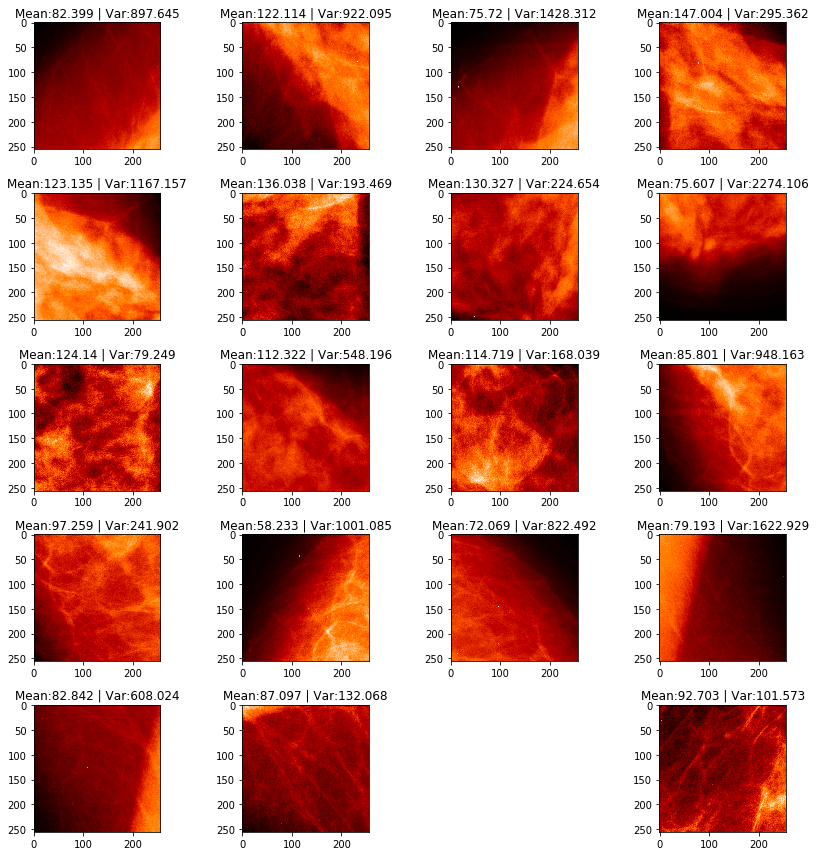

In [39]:
N = 16
idxs = random.sample(range(len(norm09_patches)), k=N)
plt.figure(figsize=(12,12))
for i, idx in enumerate(idxs):
    plt.subplot(5,4,i+1)
    plt.imshow(norm09_patches[i].reshape(256, 256), cmap ='gist_heat')
    plt.title("Mean:" + str(round(np.mean(norm09_patches[i]),3)) + " | Var:" + str(round(np.var(norm09_patches[i]),3)))
    plt.tight_layout() 
plt.show()

In [40]:
#normalize patch images
norm09_patches = norm09_patches.astype(np.uint8)

In [41]:
np.save(os.path.join("Processed_norm_256", "lumisys_patches_norm09.npy"), norm09_patches)
np.save(os.path.join("Processed_norm_256", "lumisys_labels_norm09.npy"), norm09_labels)
np.save(os.path.join("Processed_norm_256", "lumisys_FileNames_norm09.npy"), norm09_FNs)

In [42]:
#Howteck Normal10
src = 'Normal/Lumisys/Normal10/'
norm10_patches, norm10_labels, norm10_FNs = normal_patch_slices(src, upper_thresh=10000, lower_thresh=10, mean_thresh=28, stride=300)

  0%|                                                                                           | 0/92 [00:00<?, ?it/s]

0 - B_3660_1.LEFT_CC.png


  1%|▉                                                                                  | 1/92 [00:00<01:03,  1.44it/s]

125 - B_3660_1.LEFT_MLO.png


  2%|█▊                                                                                 | 2/92 [00:01<01:07,  1.34it/s]

139 - B_3660_1.RIGHT_CC.png


  3%|██▋                                                                                | 3/92 [00:02<01:04,  1.38it/s]

125 - B_3660_1.RIGHT_MLO.png


  4%|███▌                                                                               | 4/92 [00:02<01:03,  1.38it/s]

125 - B_3661_1.LEFT_CC.png


  5%|████▌                                                                              | 5/92 [00:03<01:03,  1.38it/s]

125 - B_3661_1.LEFT_MLO.png


  7%|█████▍                                                                             | 6/92 [00:04<01:03,  1.36it/s]

125 - B_3661_1.RIGHT_CC.png


  8%|██████▎                                                                            | 7/92 [00:05<01:01,  1.38it/s]

125 - B_3661_1.RIGHT_MLO.png


  9%|███████▏                                                                           | 8/92 [00:05<01:02,  1.35it/s]

125 - B_3662_1.LEFT_CC.png


 10%|████████                                                                           | 9/92 [00:06<00:59,  1.39it/s]

125 - B_3662_1.LEFT_MLO.png


 11%|████████▉                                                                         | 10/92 [00:07<00:58,  1.39it/s]

125 - B_3662_1.RIGHT_CC.png


 12%|█████████▊                                                                        | 11/92 [00:07<00:56,  1.43it/s]

125 - B_3662_1.RIGHT_MLO.png


 13%|██████████▋                                                                       | 12/92 [00:08<00:54,  1.47it/s]

125 - B_3663_1.LEFT_CC.png


 14%|███████████▌                                                                      | 13/92 [00:09<00:54,  1.45it/s]

125 - B_3663_1.LEFT_MLO.png


 15%|████████████▍                                                                     | 14/92 [00:10<00:56,  1.39it/s]

125 - B_3663_1.RIGHT_CC.png


 16%|█████████████▎                                                                    | 15/92 [00:10<00:55,  1.40it/s]

125 - B_3663_1.RIGHT_MLO.png


 17%|██████████████▎                                                                   | 16/92 [00:11<00:54,  1.39it/s]

125 - B_3664_1.LEFT_CC.png


 18%|███████████████▏                                                                  | 17/92 [00:12<00:54,  1.38it/s]

125 - B_3664_1.LEFT_MLO.png


 20%|████████████████                                                                  | 18/92 [00:13<00:55,  1.34it/s]

125 - B_3664_1.RIGHT_CC.png


 21%|████████████████▉                                                                 | 19/92 [00:13<00:52,  1.39it/s]

125 - B_3664_1.RIGHT_MLO.png


 22%|█████████████████▊                                                                | 20/92 [00:14<00:51,  1.39it/s]

125 - B_3665_1.LEFT_CC.png


 23%|██████████████████▋                                                               | 21/92 [00:15<00:49,  1.43it/s]

125 - B_3665_1.LEFT_MLO.png


 24%|███████████████████▌                                                              | 22/92 [00:15<00:47,  1.47it/s]

125 - B_3665_1.RIGHT_CC.png


 25%|████████████████████▌                                                             | 23/92 [00:16<00:46,  1.49it/s]

125 - B_3665_1.RIGHT_MLO.png


 26%|█████████████████████▍                                                            | 24/92 [00:16<00:44,  1.54it/s]

125 - B_3666_1.LEFT_CC.png


 27%|██████████████████████▎                                                           | 25/92 [00:17<00:46,  1.45it/s]

125 - B_3666_1.LEFT_MLO.png


 28%|███████████████████████▏                                                          | 26/92 [00:18<00:48,  1.37it/s]

125 - B_3666_1.RIGHT_CC.png


 29%|████████████████████████                                                          | 27/92 [00:19<00:49,  1.32it/s]

125 - B_3666_1.RIGHT_MLO.png


 30%|████████████████████████▉                                                         | 28/92 [00:20<00:49,  1.30it/s]

125 - B_3667_1.LEFT_CC.png


 32%|█████████████████████████▊                                                        | 29/92 [00:21<00:50,  1.25it/s]

139 - B_3667_1.LEFT_MLO.png


 33%|██████████████████████████▋                                                       | 30/92 [00:21<00:51,  1.20it/s]

139 - B_3667_1.RIGHT_CC.png


 34%|███████████████████████████▋                                                      | 31/92 [00:22<00:51,  1.19it/s]

139 - B_3667_1.RIGHT_MLO.png


 35%|████████████████████████████▌                                                     | 32/92 [00:23<00:50,  1.18it/s]

139 - B_3668_1.LEFT_CC.png


 36%|█████████████████████████████▍                                                    | 33/92 [00:24<00:48,  1.21it/s]

125 - B_3668_1.LEFT_MLO.png


 37%|██████████████████████████████▎                                                   | 34/92 [00:25<00:47,  1.22it/s]

125 - B_3668_1.RIGHT_CC.png


 38%|███████████████████████████████▏                                                  | 35/92 [00:26<00:45,  1.26it/s]

125 - B_3668_1.RIGHT_MLO.png


 39%|████████████████████████████████                                                  | 36/92 [00:26<00:43,  1.28it/s]

125 - B_3669_1.LEFT_CC.png


 40%|████████████████████████████████▉                                                 | 37/92 [00:27<00:49,  1.10it/s]

203 - B_3669_1.LEFT_MLO.png


 41%|█████████████████████████████████▊                                                | 38/92 [00:29<00:53,  1.00it/s]

203 - B_3669_1.RIGHT_CC.png


 42%|██████████████████████████████████▊                                               | 39/92 [00:30<00:55,  1.05s/it]

203 - B_3669_1.RIGHT_MLO.png


 43%|███████████████████████████████████▋                                              | 40/92 [00:31<00:57,  1.11s/it]

203 - B_3670_1.LEFT_CC.png


 45%|████████████████████████████████████▌                                             | 41/92 [00:32<00:51,  1.01s/it]

139 - B_3670_1.LEFT_MLO.png


 46%|█████████████████████████████████████▍                                            | 42/92 [00:33<00:47,  1.06it/s]

139 - B_3670_1.RIGHT_CC.png


 47%|██████████████████████████████████████▎                                           | 43/92 [00:33<00:43,  1.13it/s]

125 - B_3670_1.RIGHT_MLO.png


 48%|███████████████████████████████████████▏                                          | 44/92 [00:34<00:41,  1.16it/s]

139 - B_3671_1.LEFT_CC.png


 49%|████████████████████████████████████████                                          | 45/92 [00:35<00:37,  1.26it/s]

125 - B_3671_1.LEFT_MLO.png


 50%|█████████████████████████████████████████                                         | 46/92 [00:36<00:34,  1.32it/s]

125 - B_3671_1.RIGHT_CC.png


 51%|█████████████████████████████████████████▉                                        | 47/92 [00:36<00:32,  1.40it/s]

125 - B_3671_1.RIGHT_MLO.png


 52%|██████████████████████████████████████████▊                                       | 48/92 [00:37<00:30,  1.45it/s]

125 - B_3672_1.LEFT_CC.png


 53%|███████████████████████████████████████████▋                                      | 49/92 [00:38<00:36,  1.19it/s]

203 - B_3672_1.LEFT_MLO.png


 54%|████████████████████████████████████████████▌                                     | 50/92 [00:39<00:39,  1.05it/s]

203 - B_3672_1.RIGHT_CC.png


 55%|█████████████████████████████████████████████▍                                    | 51/92 [00:40<00:41,  1.00s/it]

203 - B_3672_1.RIGHT_MLO.png


 57%|██████████████████████████████████████████████▎                                   | 52/92 [00:41<00:41,  1.04s/it]

203 - B_3673_1.LEFT_CC.png


 58%|███████████████████████████████████████████████▏                                  | 53/92 [00:43<00:41,  1.07s/it]

203 - B_3673_1.LEFT_MLO.png


 59%|████████████████████████████████████████████████▏                                 | 54/92 [00:44<00:42,  1.12s/it]

215 - B_3673_1.RIGHT_CC.png


 60%|█████████████████████████████████████████████████                                 | 55/92 [00:45<00:41,  1.13s/it]

203 - B_3673_1.RIGHT_MLO.png


 61%|█████████████████████████████████████████████████▉                                | 56/92 [00:46<00:41,  1.16s/it]

215 - B_3674_1.LEFT_CC.png


 62%|██████████████████████████████████████████████████▊                               | 57/92 [00:47<00:38,  1.11s/it]

167 - B_3674_1.LEFT_MLO.png


 63%|███████████████████████████████████████████████████▋                              | 58/92 [00:48<00:37,  1.11s/it]

179 - B_3674_1.RIGHT_CC.png


 64%|████████████████████████████████████████████████████▌                             | 59/92 [00:49<00:34,  1.06s/it]

167 - B_3674_1.RIGHT_MLO.png


 65%|█████████████████████████████████████████████████████▍                            | 60/92 [00:50<00:33,  1.05s/it]

167 - B_3675_1.LEFT_CC.png


 66%|██████████████████████████████████████████████████████▎                           | 61/92 [00:51<00:29,  1.04it/s]

125 - B_3675_1.LEFT_MLO.png


 67%|███████████████████████████████████████████████████████▎                          | 62/92 [00:52<00:27,  1.10it/s]

125 - B_3675_1.RIGHT_CC.png


 68%|████████████████████████████████████████████████████████▏                         | 63/92 [00:53<00:24,  1.17it/s]

125 - B_3675_1.RIGHT_MLO.png


 70%|█████████████████████████████████████████████████████████                         | 64/92 [00:53<00:23,  1.21it/s]

125 - B_3676_1.LEFT_CC.png


 71%|█████████████████████████████████████████████████████████▉                        | 65/92 [00:55<00:25,  1.05it/s]

203 - B_3676_1.LEFT_MLO.png


 72%|██████████████████████████████████████████████████████████▊                       | 66/92 [00:56<00:27,  1.06s/it]

203 - B_3676_1.RIGHT_CC.png


 73%|███████████████████████████████████████████████████████████▋                      | 67/92 [00:57<00:27,  1.09s/it]

203 - B_3676_1.RIGHT_MLO.png


 74%|████████████████████████████████████████████████████████████▌                     | 68/92 [00:58<00:27,  1.14s/it]

203 - B_3677_1.LEFT_CC.png


 75%|█████████████████████████████████████████████████████████████▌                    | 69/92 [00:59<00:23,  1.01s/it]

125 - B_3677_1.LEFT_MLO.png


 76%|██████████████████████████████████████████████████████████████▍                   | 70/92 [01:00<00:20,  1.06it/s]

125 - B_3677_1.RIGHT_CC.png


 77%|███████████████████████████████████████████████████████████████▎                  | 71/92 [01:00<00:18,  1.14it/s]

125 - B_3677_1.RIGHT_MLO.png


 78%|████████████████████████████████████████████████████████████████▏                 | 72/92 [01:01<00:16,  1.22it/s]

125 - B_3678_1.LEFT_CC.png


 79%|█████████████████████████████████████████████████████████████████                 | 73/92 [01:02<00:14,  1.30it/s]

125 - B_3678_1.LEFT_MLO.png


 80%|█████████████████████████████████████████████████████████████████▉                | 74/92 [01:03<00:13,  1.34it/s]

125 - B_3678_1.RIGHT_CC.png


 82%|██████████████████████████████████████████████████████████████████▊               | 75/92 [01:03<00:12,  1.41it/s]

125 - B_3678_1.RIGHT_MLO.png


 83%|███████████████████████████████████████████████████████████████████▋              | 76/92 [01:04<00:11,  1.43it/s]

125 - B_3679_1.LEFT_CC.png


 84%|████████████████████████████████████████████████████████████████████▋             | 77/92 [01:05<00:10,  1.43it/s]

125 - B_3679_1.LEFT_MLO.png


 85%|█████████████████████████████████████████████████████████████████████▌            | 78/92 [01:05<00:09,  1.40it/s]

125 - B_3679_1.RIGHT_CC.png


 86%|██████████████████████████████████████████████████████████████████████▍           | 79/92 [01:06<00:09,  1.41it/s]

125 - B_3679_1.RIGHT_MLO.png


 87%|███████████████████████████████████████████████████████████████████████▎          | 80/92 [01:07<00:08,  1.40it/s]

125 - B_3680_1.LEFT_CC.png


 88%|████████████████████████████████████████████████████████████████████████▏         | 81/92 [01:07<00:07,  1.44it/s]

125 - B_3680_1.LEFT_MLO.png


 89%|█████████████████████████████████████████████████████████████████████████         | 82/92 [01:08<00:06,  1.44it/s]

125 - B_3680_1.RIGHT_CC.png


 90%|█████████████████████████████████████████████████████████████████████████▉        | 83/92 [01:09<00:06,  1.48it/s]

125 - B_3680_1.RIGHT_MLO.png


 91%|██████████████████████████████████████████████████████████████████████████▊       | 84/92 [01:09<00:05,  1.48it/s]

125 - B_3681_1.LEFT_CC.png


 92%|███████████████████████████████████████████████████████████████████████████▊      | 85/92 [01:10<00:04,  1.44it/s]

125 - B_3681_1.LEFT_MLO.png


 93%|████████████████████████████████████████████████████████████████████████████▋     | 86/92 [01:11<00:04,  1.39it/s]

125 - B_3681_1.RIGHT_CC.png


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 87/92 [01:12<00:03,  1.41it/s]

125 - B_3681_1.RIGHT_MLO.png


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 88/92 [01:12<00:02,  1.40it/s]

125 - B_3682_1.LEFT_CC.png


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 89/92 [01:13<00:02,  1.40it/s]

125 - B_3682_1.LEFT_MLO.png


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 90/92 [01:14<00:01,  1.36it/s]

125 - B_3682_1.RIGHT_CC.png


 99%|█████████████████████████████████████████████████████████████████████████████████ | 91/92 [01:14<00:00,  1.36it/s]

125 - B_3682_1.RIGHT_MLO.png


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [01:15<00:00,  1.22it/s]


In [43]:
print("Lumisys Normal10 Patches:", len(norm10_patches))
print("Lumisys Normal10 Labels:", len(norm10_labels))
print("Lumisys Normal10 Labels:", len(norm10_FNs))

Lumisys Normal10 Patches: 3819
Lumisys Normal10 Labels: 3819
Lumisys Normal10 Labels: 3819


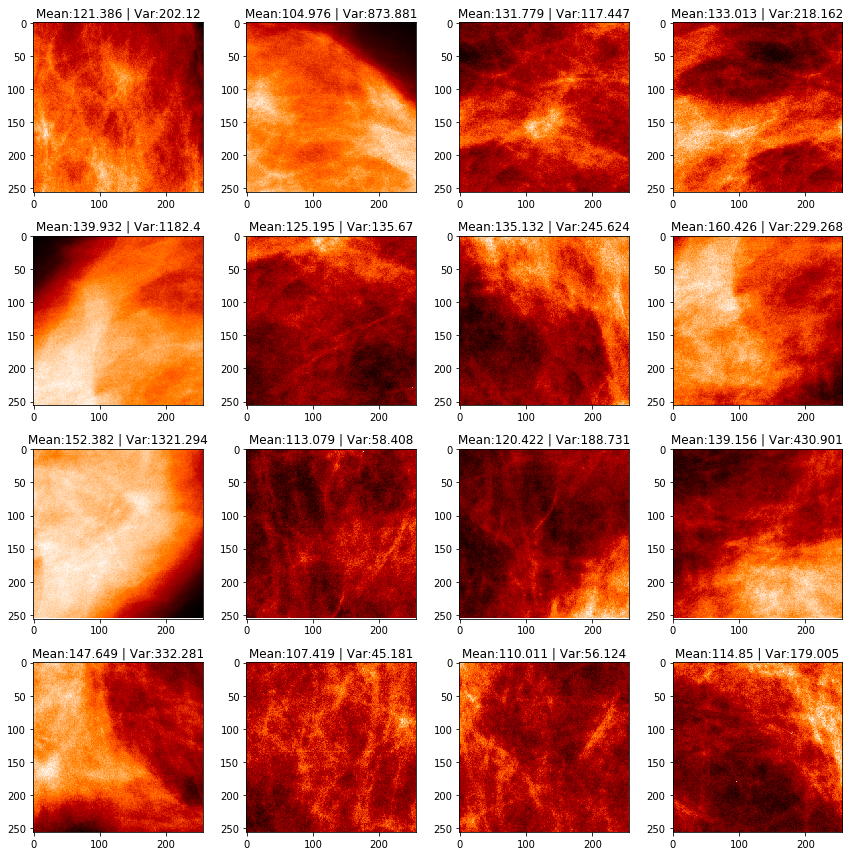

In [45]:
N = 16
idxs = random.sample(range(len(norm10_patches)), k=N)
plt.figure(figsize=(12,12))
for i, idx in enumerate(idxs):
    plt.subplot(4,4,i+1)
    plt.imshow(norm10_patches[i].reshape(256, 256), cmap ='gist_heat')
    plt.title("Mean:" + str(round(np.mean(norm10_patches[i]),3)) + " | Var:" + str(round(np.var(norm10_patches[i]),3)))
    plt.tight_layout() 
plt.show()

In [46]:
#Convert to 8bit patch images
norm10_patches = norm10_patches.astype(np.uint8)

In [47]:
np.save(os.path.join("Processed_norm_256", "lumisys_patches_norm10.npy"), norm10_patches)
np.save(os.path.join("Processed_norm_256", "lumisys_labels_norm10.npy"), norm10_labels)
np.save(os.path.join("Processed_norm_256", "lumisys_FileNames_norm10.npy"), norm10_FNs)

**All Lumisys**

In [48]:
lumisys_patches = np.concatenate([norm09_patches, norm10_patches], axis = 0)
lumisys_labels = np.concatenate([norm09_labels, norm10_labels], axis = 0)
lumisys_FNs = np.concatenate([norm09_labels, norm10_labels], axis = 0)

In [49]:
np.save(os.path.join("Processed_norm_256", "lumisys_patches_all.npy"), lumisys_patches)
np.save(os.path.join("Processed_norm_256", "lumisys_labels_all.npy"), lumisys_labels)
np.save(os.path.join("Processed_norm_256", "lumisys_FileNames_all.npy"), lumisys_FNs)